In [1]:
filename = "data/combined_data/20210917brain2.txt" #path to datafile

#formula = "C22H32O2" #dha
formula = "C20H32O2" #arachidonic

polarity = -1 #ionization polarity (1 = pos, -1 = neg)
ppmThresh = 20 #m/z tolerance, all peaks within ppmThresh ppm will be summed into one feature
convSquare = 1 #size of filter (1=1x1,3=3x3,5=5x5)
colormap = "gray" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
num_cores = 20 #number of processor cores to use
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
filt = "GB" #filtering method (GB = gaussian blur, MA = moving average)

In [2]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import os
matplotlib.rcParams['figure.dpi'] = 100
import helper
import molmass
from PIL import Image
from multiprocessing import Pool
import importlib
importlib.reload(helper)
import zipfile
from sklearn.metrics import r2_score

def getISAEq(numCarbons):
    d = {16:helper.palmitateISA,14:helper.myristicISA,18:helper.stearicISA,20:helper.arachidonicISA,22:helper.dhaISA}
    return d[numCarbons]

In [3]:
#load in data and organize
data = [r.strip().split() for r in open(filename,"r").readlines()[3:]]
data = {(x[0],float(x[1]),float(x[2])):{mz:float(i) for mz,i in zip(data[0],x[3:])} for x in data[1:] if len(x) > 0}
data = pd.DataFrame.from_dict(data,orient="index")
cols = data.columns.values
mzs = cols

palmitate_formula = "C16H32O2"

ISA_funcs = {}
mzMatchDict = {}

for form in [formula,palmitate_formula]:
    #get formulas
    f = molmass.Formula(form) #create formula object
    m0Mz = f.isotope.mass #get monoisotopcic mass for product ion
    adductChange = polarity * 1.0077276 #calculate adduct m/z

    #get number of carbons
    comp = f.composition()
    for row in comp:
        if row[0] == "C":
            numCarbons = int(row[1])
    func = getISAEq(numCarbons) #get relevant ISA equation
    ISA_funcs[form] = func

    #get mzs of interest
    mzsOI = [m0Mz+adductChange+1.00336*x for x in range(numCarbons+1)]
    
    mzMatchDict[form] = {i:{"true":m,"observed":[],"matched":False} for m,i in zip(mzsOI,range(len(mzsOI)))}

    #find matching peaks in data and output found and missing peaks
    for m,i in zip(mzsOI,range(len(mzsOI))):
        matched = False
        for m2 in mzs:
            tmpM2 = float(m2)
            if abs(m-tmpM2) / m * 1e6 < ppmThresh:
                mzMatchDict[form][i]["observed"].append(m2)
                mzMatchDict[form][i]["matched"] = True
                matched = True
                break
        if not matched:
            print("missed",m)
        else:
            print("found",m,mzMatchDict[form][i]["observed"])


found 303.23250267049997 ['303.2321']
found 304.23586267049996 ['304.2354']
found 305.23922267049994 ['305.2405']
found 306.2425826705 ['306.2449']
missed 307.24594267049997
missed 308.24930267049996
missed 309.25266267049994
missed 310.2560226705
missed 311.2593826705
missed 312.26274267049996
missed 313.26610267049995
missed 314.2694626705
missed 315.2728226705
missed 316.27618267049996
missed 317.27954267049995
missed 318.2829026705
missed 319.2862626705
missed 320.28962267049997
missed 321.29298267049995
missed 322.29634267049994
missed 323.2997026705
found 255.23250267049997 ['255.2319']
found 256.23586267049996 ['256.2354']
found 257.23922267049994 ['257.2376']
missed 258.2425826705
missed 259.24594267049997
missed 260.24930267049996
found 261.25266267049994 ['261.2510']
found 262.2560226705 ['262.2545']
found 263.2593826705 ['263.2580']
found 264.26274267049996 ['264.2614']
found 265.26610267049995 ['265.2647']
found 266.2694626705 ['266.2683']
found 267.2728226705 ['267.2716']


In [4]:
#gather images for mzs of interest 
tensors = {}
for form in mzMatchDict:
    tensors[form] = []
    for mz in range(len(mzMatchDict[form])):
        #iterate through mzs of interest
        if mzMatchDict[form][mz]["matched"]:   
            outarray = np.sum(np.array([helper.getImage(data,x,None,None) for x in mzMatchDict[form][mz]["observed"]]),axis=0)
            height = len(outarray)
            width = len(outarray[0])
        else:
            outarray = np.zeros((height,width))
        tensors[form].append(outarray)

    tensors[form] = np.array(tensors[form])

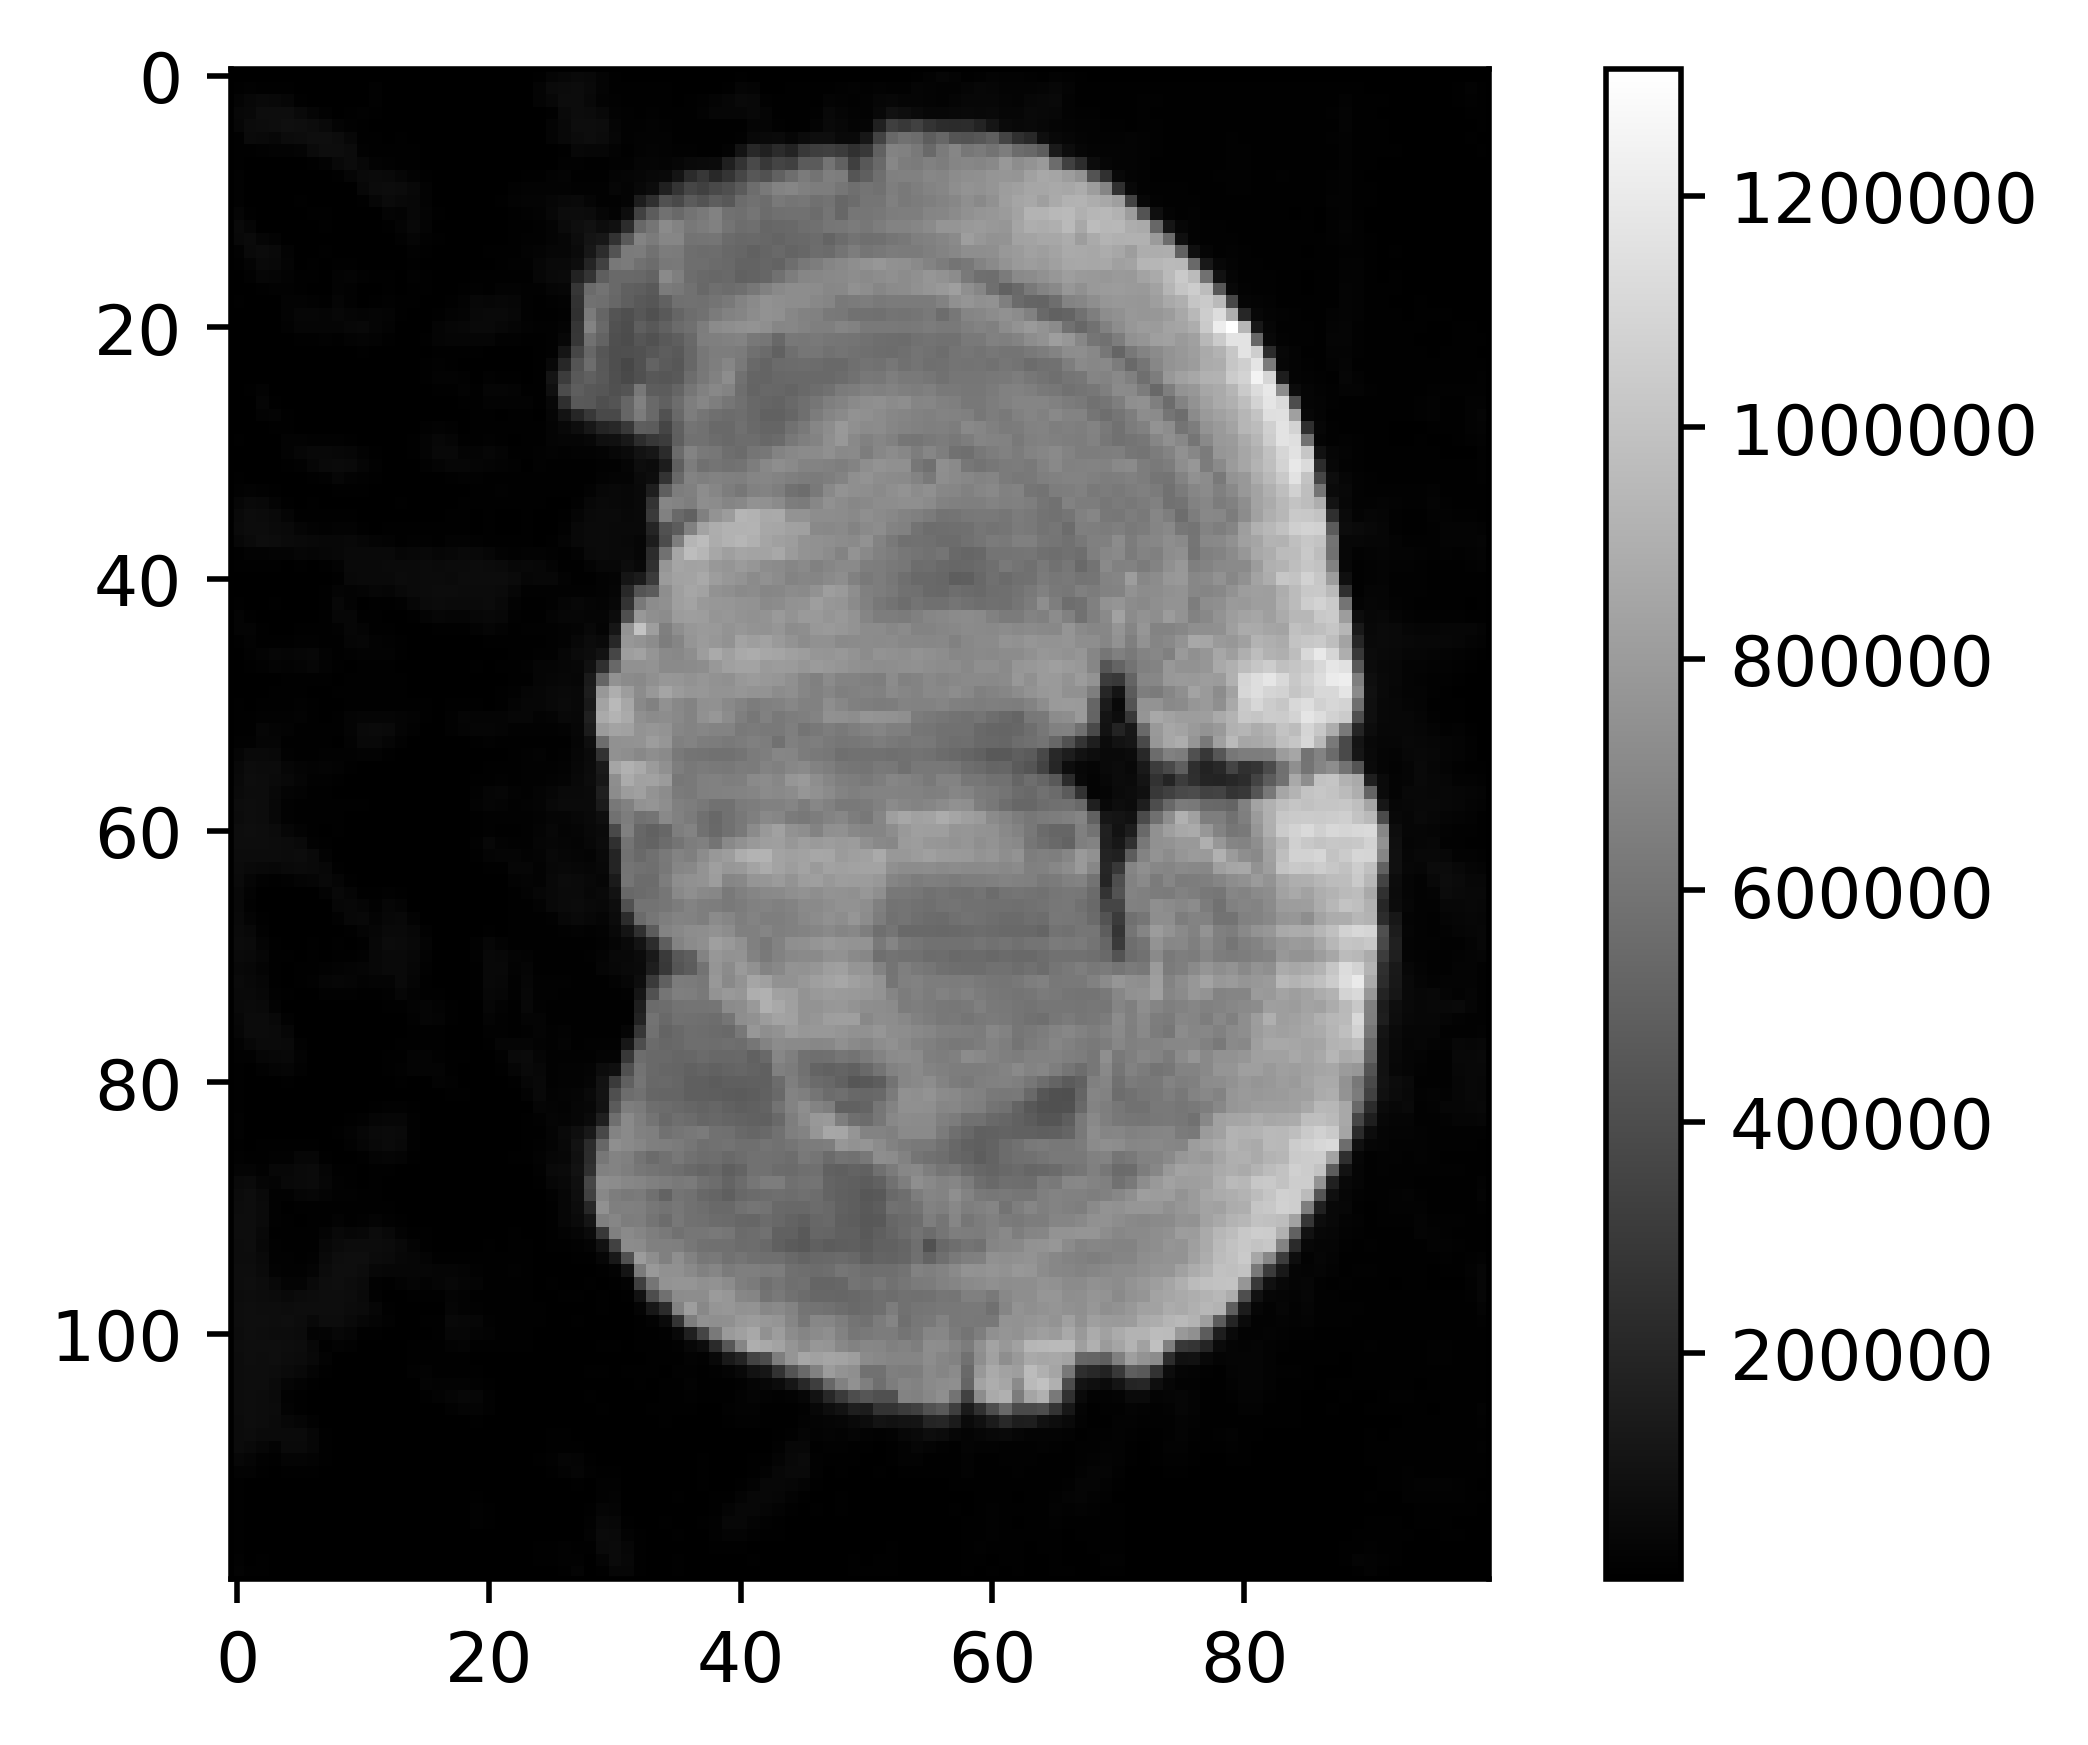

<Figure size 3000x2000 with 0 Axes>

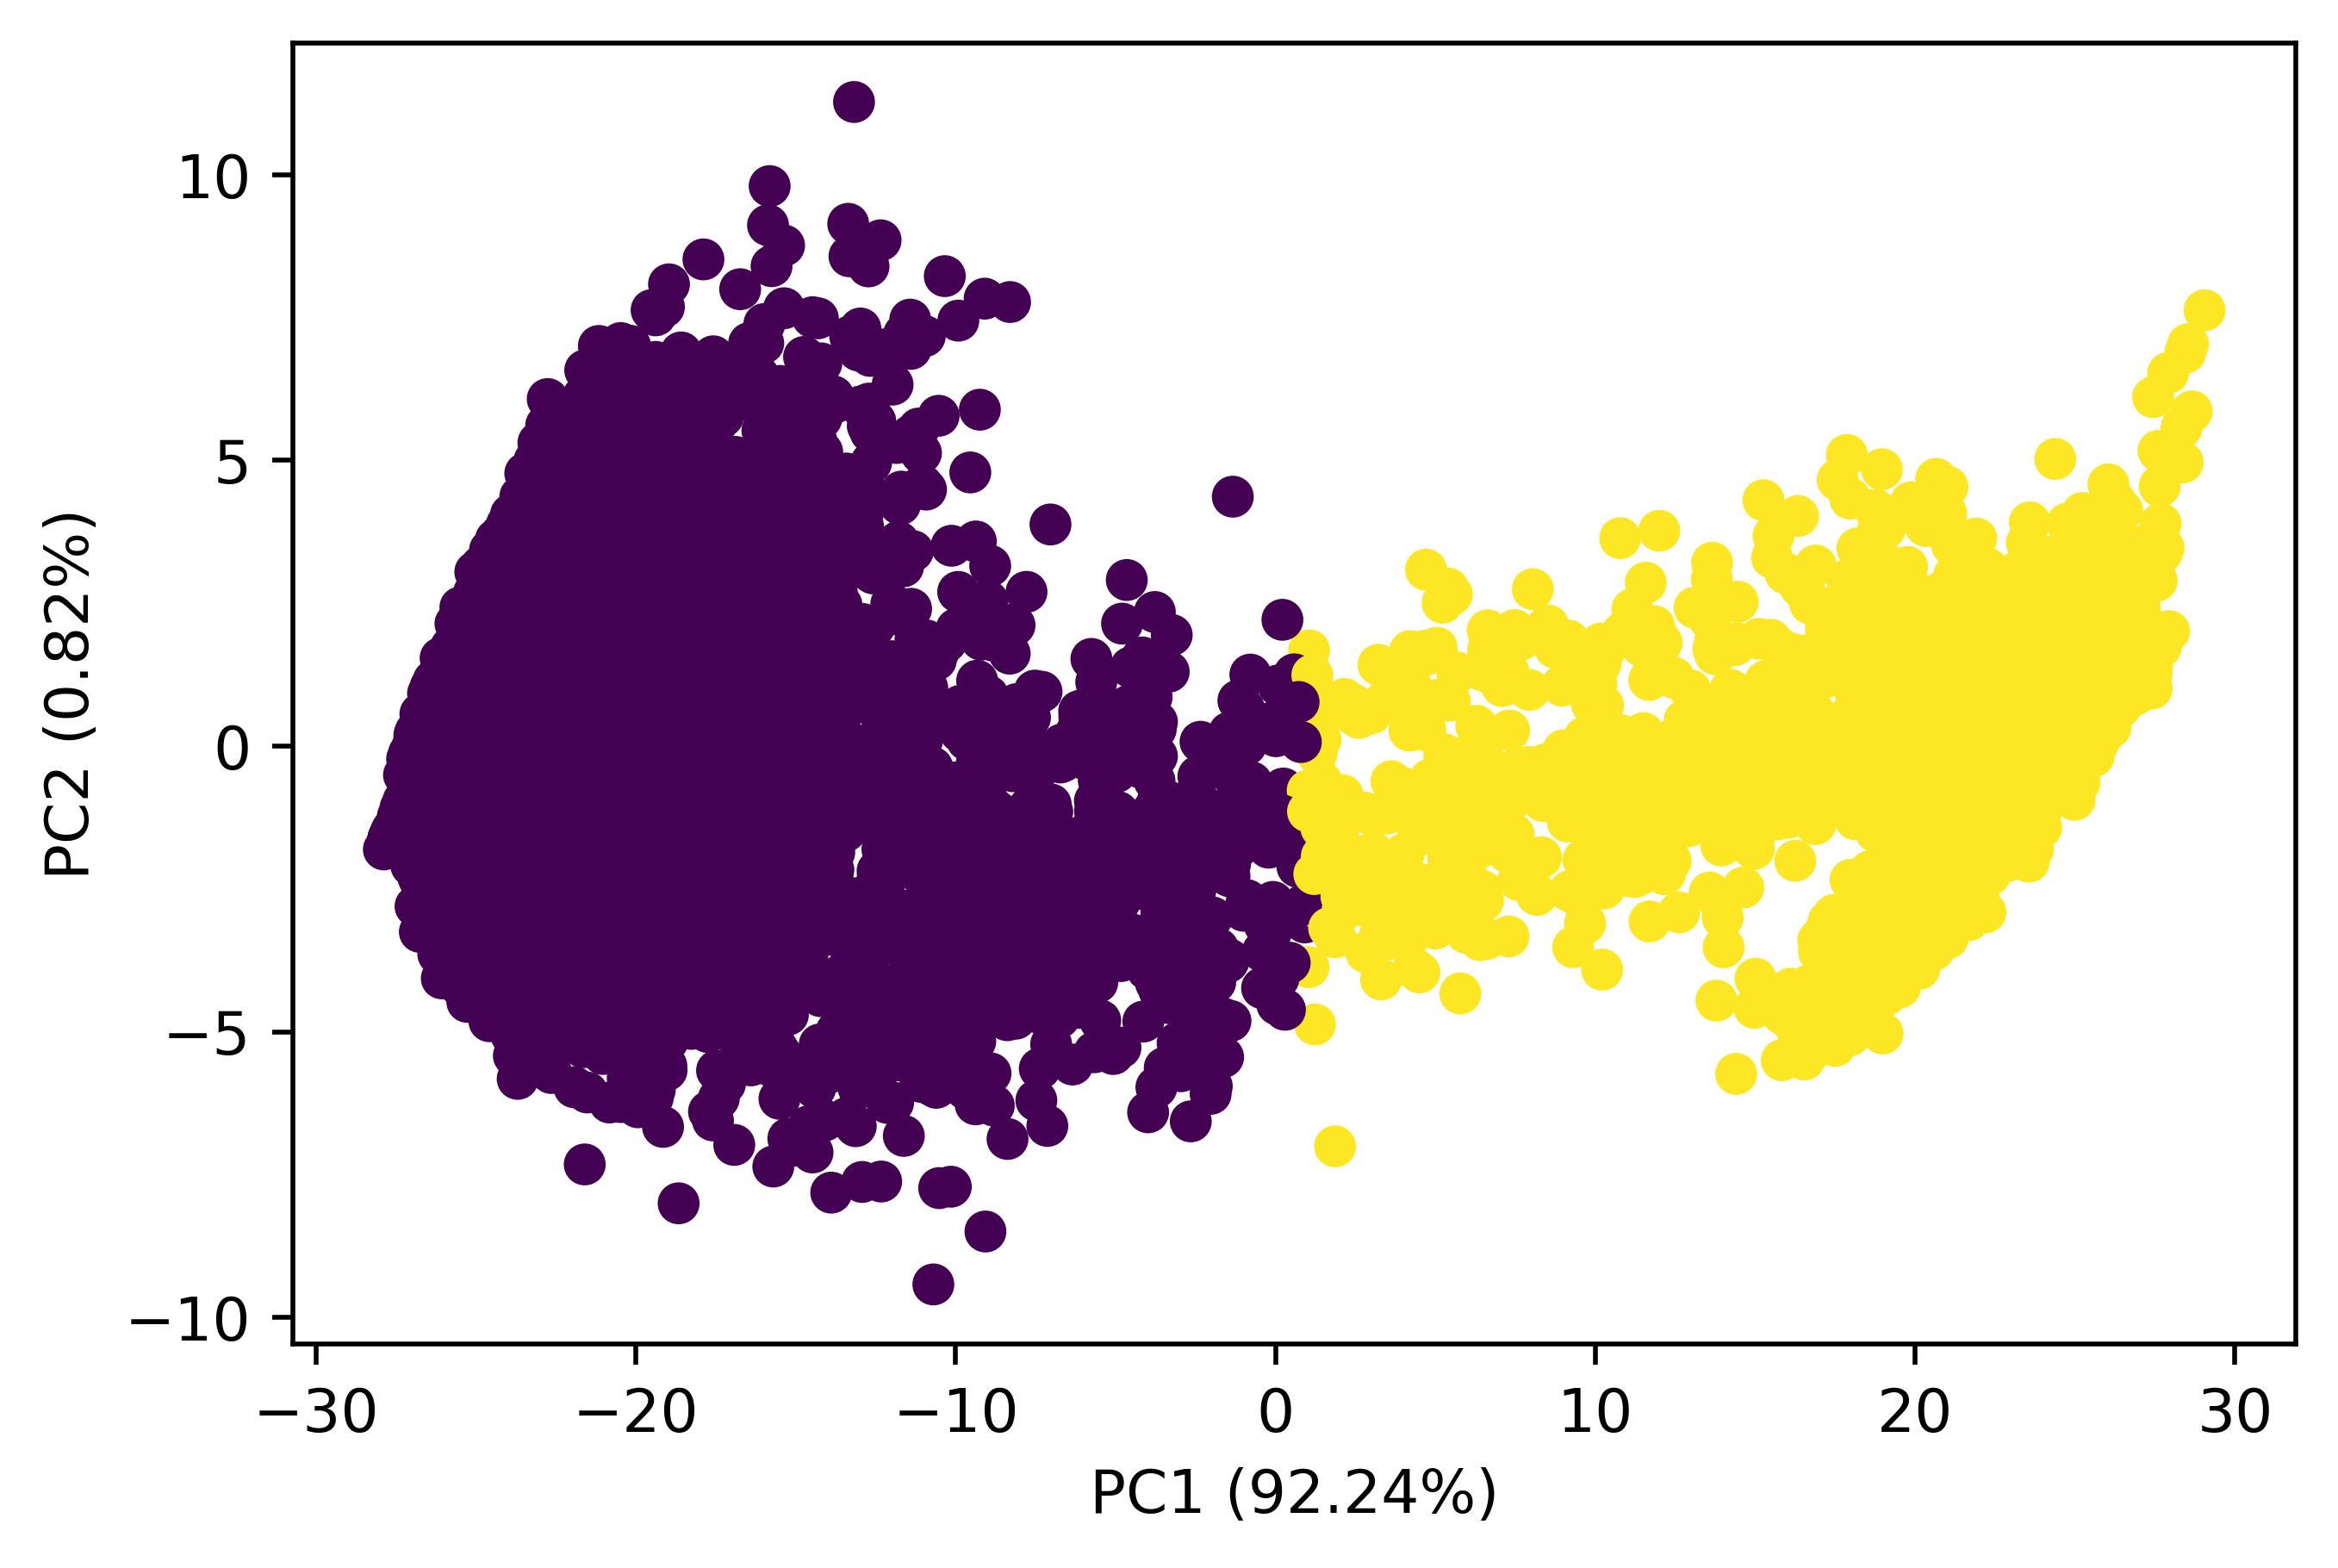

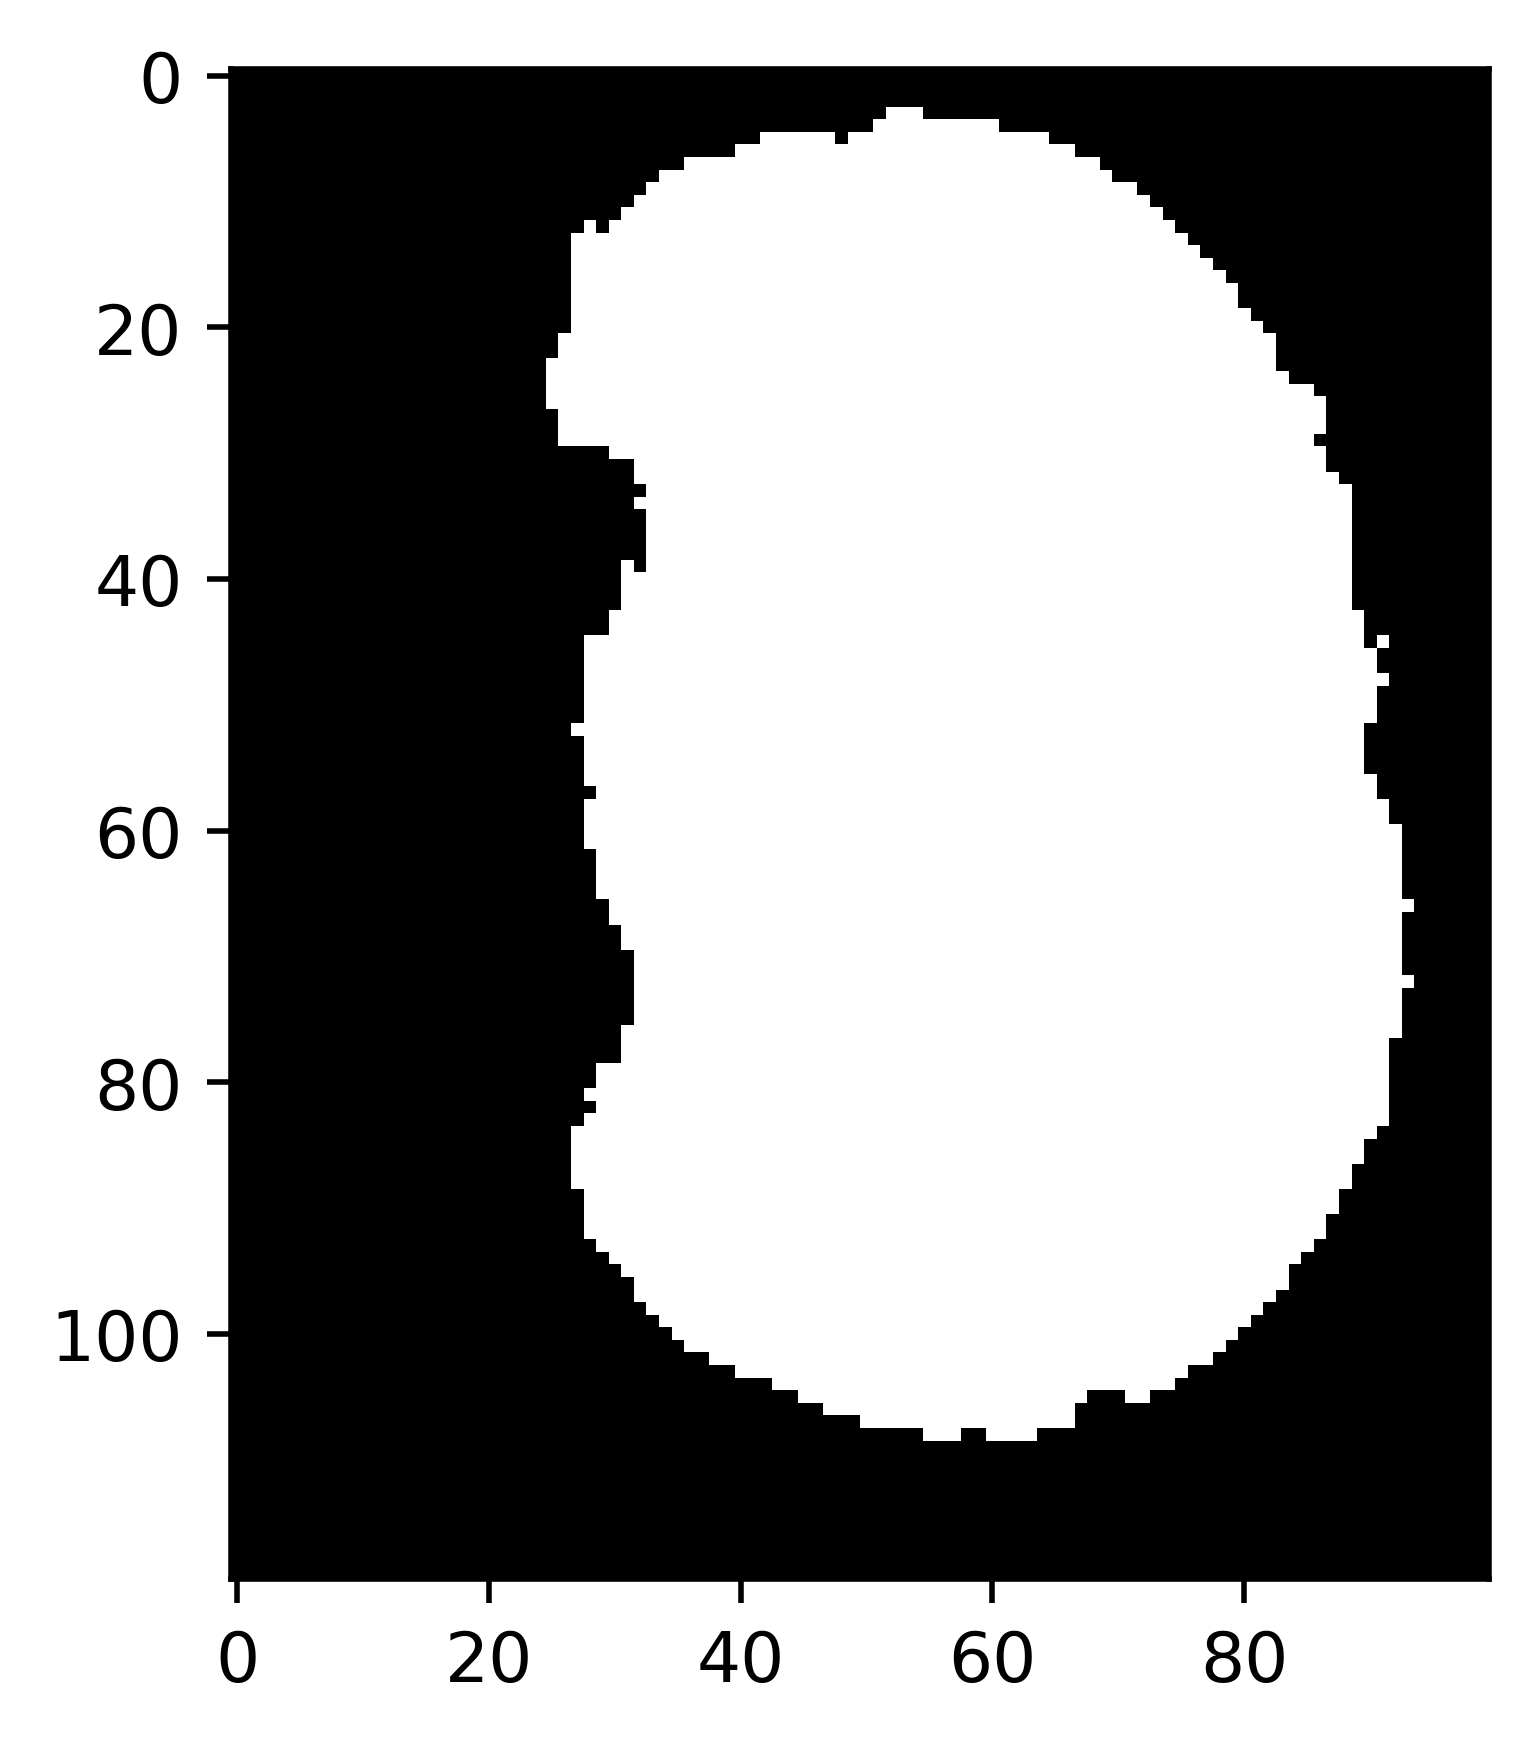

In [5]:
#get thresholded image to define sample boundary

imageBoundary = helper.segmentImage(data,height,width,mzs,colormap,method=seg_method,dm_method=dm_method,num_latent=num_components)

plt.figure()

#show masked image
plt.imshow(imageBoundary,cmap=colormap)

In [6]:

#apply moving average filter
offset = int((convSquare-1)/2)
tensorFilt = {} #new tensor for filtered image
newImageBoundary = np.zeros((height-2*offset,width-2*offset)) #new image boundary
if __name__ == "__main__":
    for form in tensors:
        pool = Pool(num_cores)
        tensorFilt[form] = np.array(pool.starmap(helper.convolveLayer,[(offset,height,width,tensors[form][t],imageBoundary,filt) for t in range(len(tensors[form]))]))
        helper.normalizeTensor(tensorFilt[form])
        pool.close()
        pool.join()

#normalize so the sum of the signal = 1


0.024046224711236183 [-0.01723068  0.70664562  0.31058507]
-0.008500934643821493 [0.29021033 0.28021197 0.4295777 ]
0.001839017241370925 [ 1.09158243 -0.26838156  0.17679913]
-0.0011997571078623344 [0.28911396 0.2803813  0.43050474]
0.0178706295703969 [ 0.9395882  -0.08867567  0.14908747]
-0.006496507395154528 [0.30712188 0.25949867 0.43337945]
-0.010923034126992892 [0.29024282 0.2800412  0.42971598]


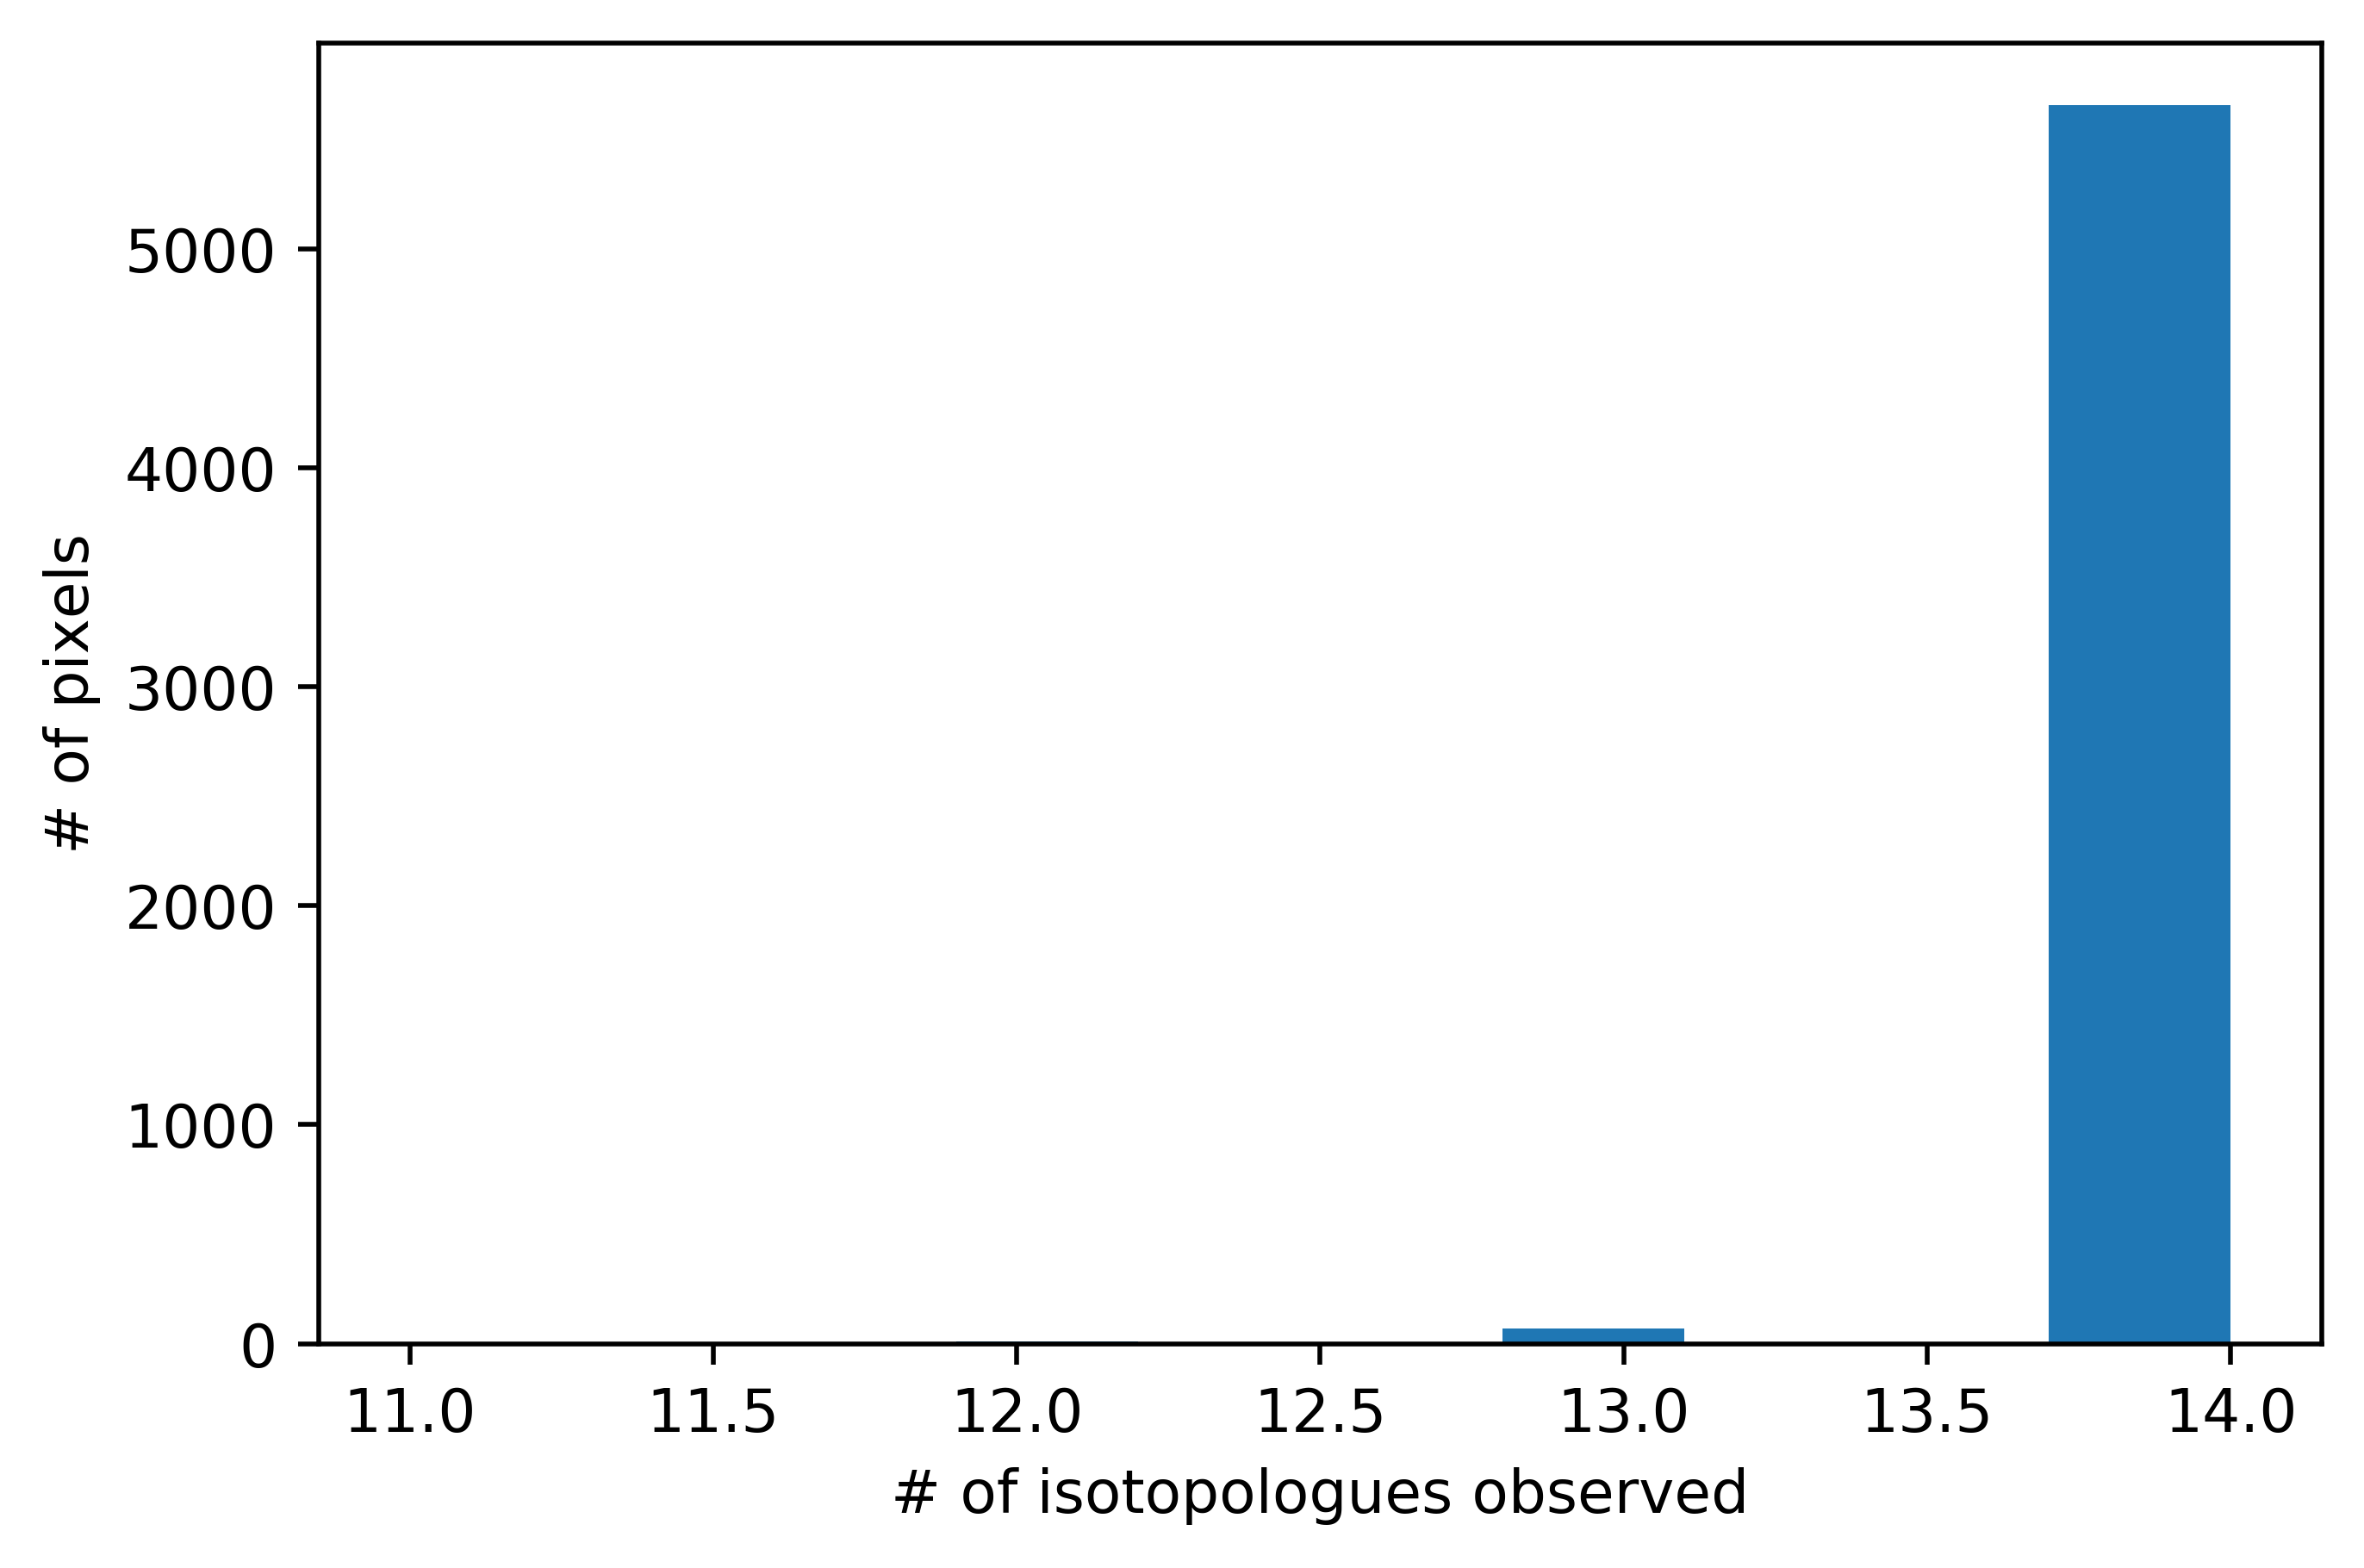

In [7]:
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
T = [0,0,1] #set initial tracer labeling

#create data structures to store output
errs = []
T_founds = []
fluxImageG = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))
fluxImageD = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))
fluxImageT0 = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))
fluxImageT1 = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))
fluxImageT2 = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))
P_consider = []
P_trues = []
P_preds = []

#do pixel by pixel ISA
argList = []
coords = []

#func = helper.palmitateISA

numFounds = []

for r in range(len(tensorFilt[palmitate_formula][0])):
    for c in range(len(tensorFilt[palmitate_formula][0][0])):
        #get palmitate labeling
        P = tensorFilt[palmitate_formula][:,r,c]

        goodInd = [x for x in range(len(P)) if P[x] > 0]

        #if not on background pixel
        if imageBoundary[r,c] > .5:
            #fit palmitate ISA
            numFounds.append(len(goodInd))
            argList.append((T,N,P,ISA_funcs[palmitate_formula],goodInd,.5))#np.random.random(1)))
            coords.append((r,c))
            P_consider.append(P)


plt.hist(numFounds)
plt.xlabel("# of isotopologues observed")
plt.ylabel("# of pixels")

if __name__ == "__main__":
    pool = Pool(num_cores)
    results = pool.starmap(helper.ISAFit,argList)
    pool.close()
    pool.join()

errors = []
Ind = 0
goodPixels = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))
for (g,D,T_found,err,P_pred),(r,c),P_true in zip(results,coords,P_consider):
    #save results in data structures
    if g > -.0001 and g < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in T_found):
        errs.append(err)
        T_founds.append(T_found)
        #P_trues.append(P)
        P_preds.append(P_pred)
        P_trues.append(P_true)
        Ind += 1
        fluxImageG[r,c] = g
        fluxImageD[r,c] = D
        fluxImageT0[r,c] = T_found[0]
        fluxImageT1[r,c] = T_found[1]
        fluxImageT2[r,c] = T_found[2]
        goodPixels[r,c] = 1.0
    else:
        print(g,T_found)
        errors.append(P_true)

-0.04370959681212883
-0.009899805926521274
-0.001228582216856536
-0.0005962705342143836
-0.004183874165222052
-0.000688031905594497
-0.0029086104314259955
-0.0002990750229434953
-0.0033659352274086644
-0.0013391395816113076
-0.004169628109525203
-0.0017871362982706256
-0.001278448173267332
-0.0013656523781018794
-0.005389955115374655
-0.005353655275413101
-0.008783005823922595
-0.0011355945981418262
-0.005525297699505621
-0.0004870151700495198
-0.0012350527219621124
-0.004528915863883394
-0.0019257729803592596
-0.004366562667258173
-0.00012457301312428714
-0.0008048175977809306
-0.0005218940698789552
-0.0017772255553897133
-0.0071746078345964566
-0.005195190205316645
-0.004312636976873006
-0.0042016756404864904
-0.010996865650708326
-0.014664994256929667
-0.0009386063977427819
-0.00029837392559161854
-0.0013297969611041896
-0.006043007686211127
-0.000923920317846132
-0.004455079818693871
-0.00029762045620618997
-0.007017317787845863
-0.007197881415830007
-0.008799500308645423
-0.004054

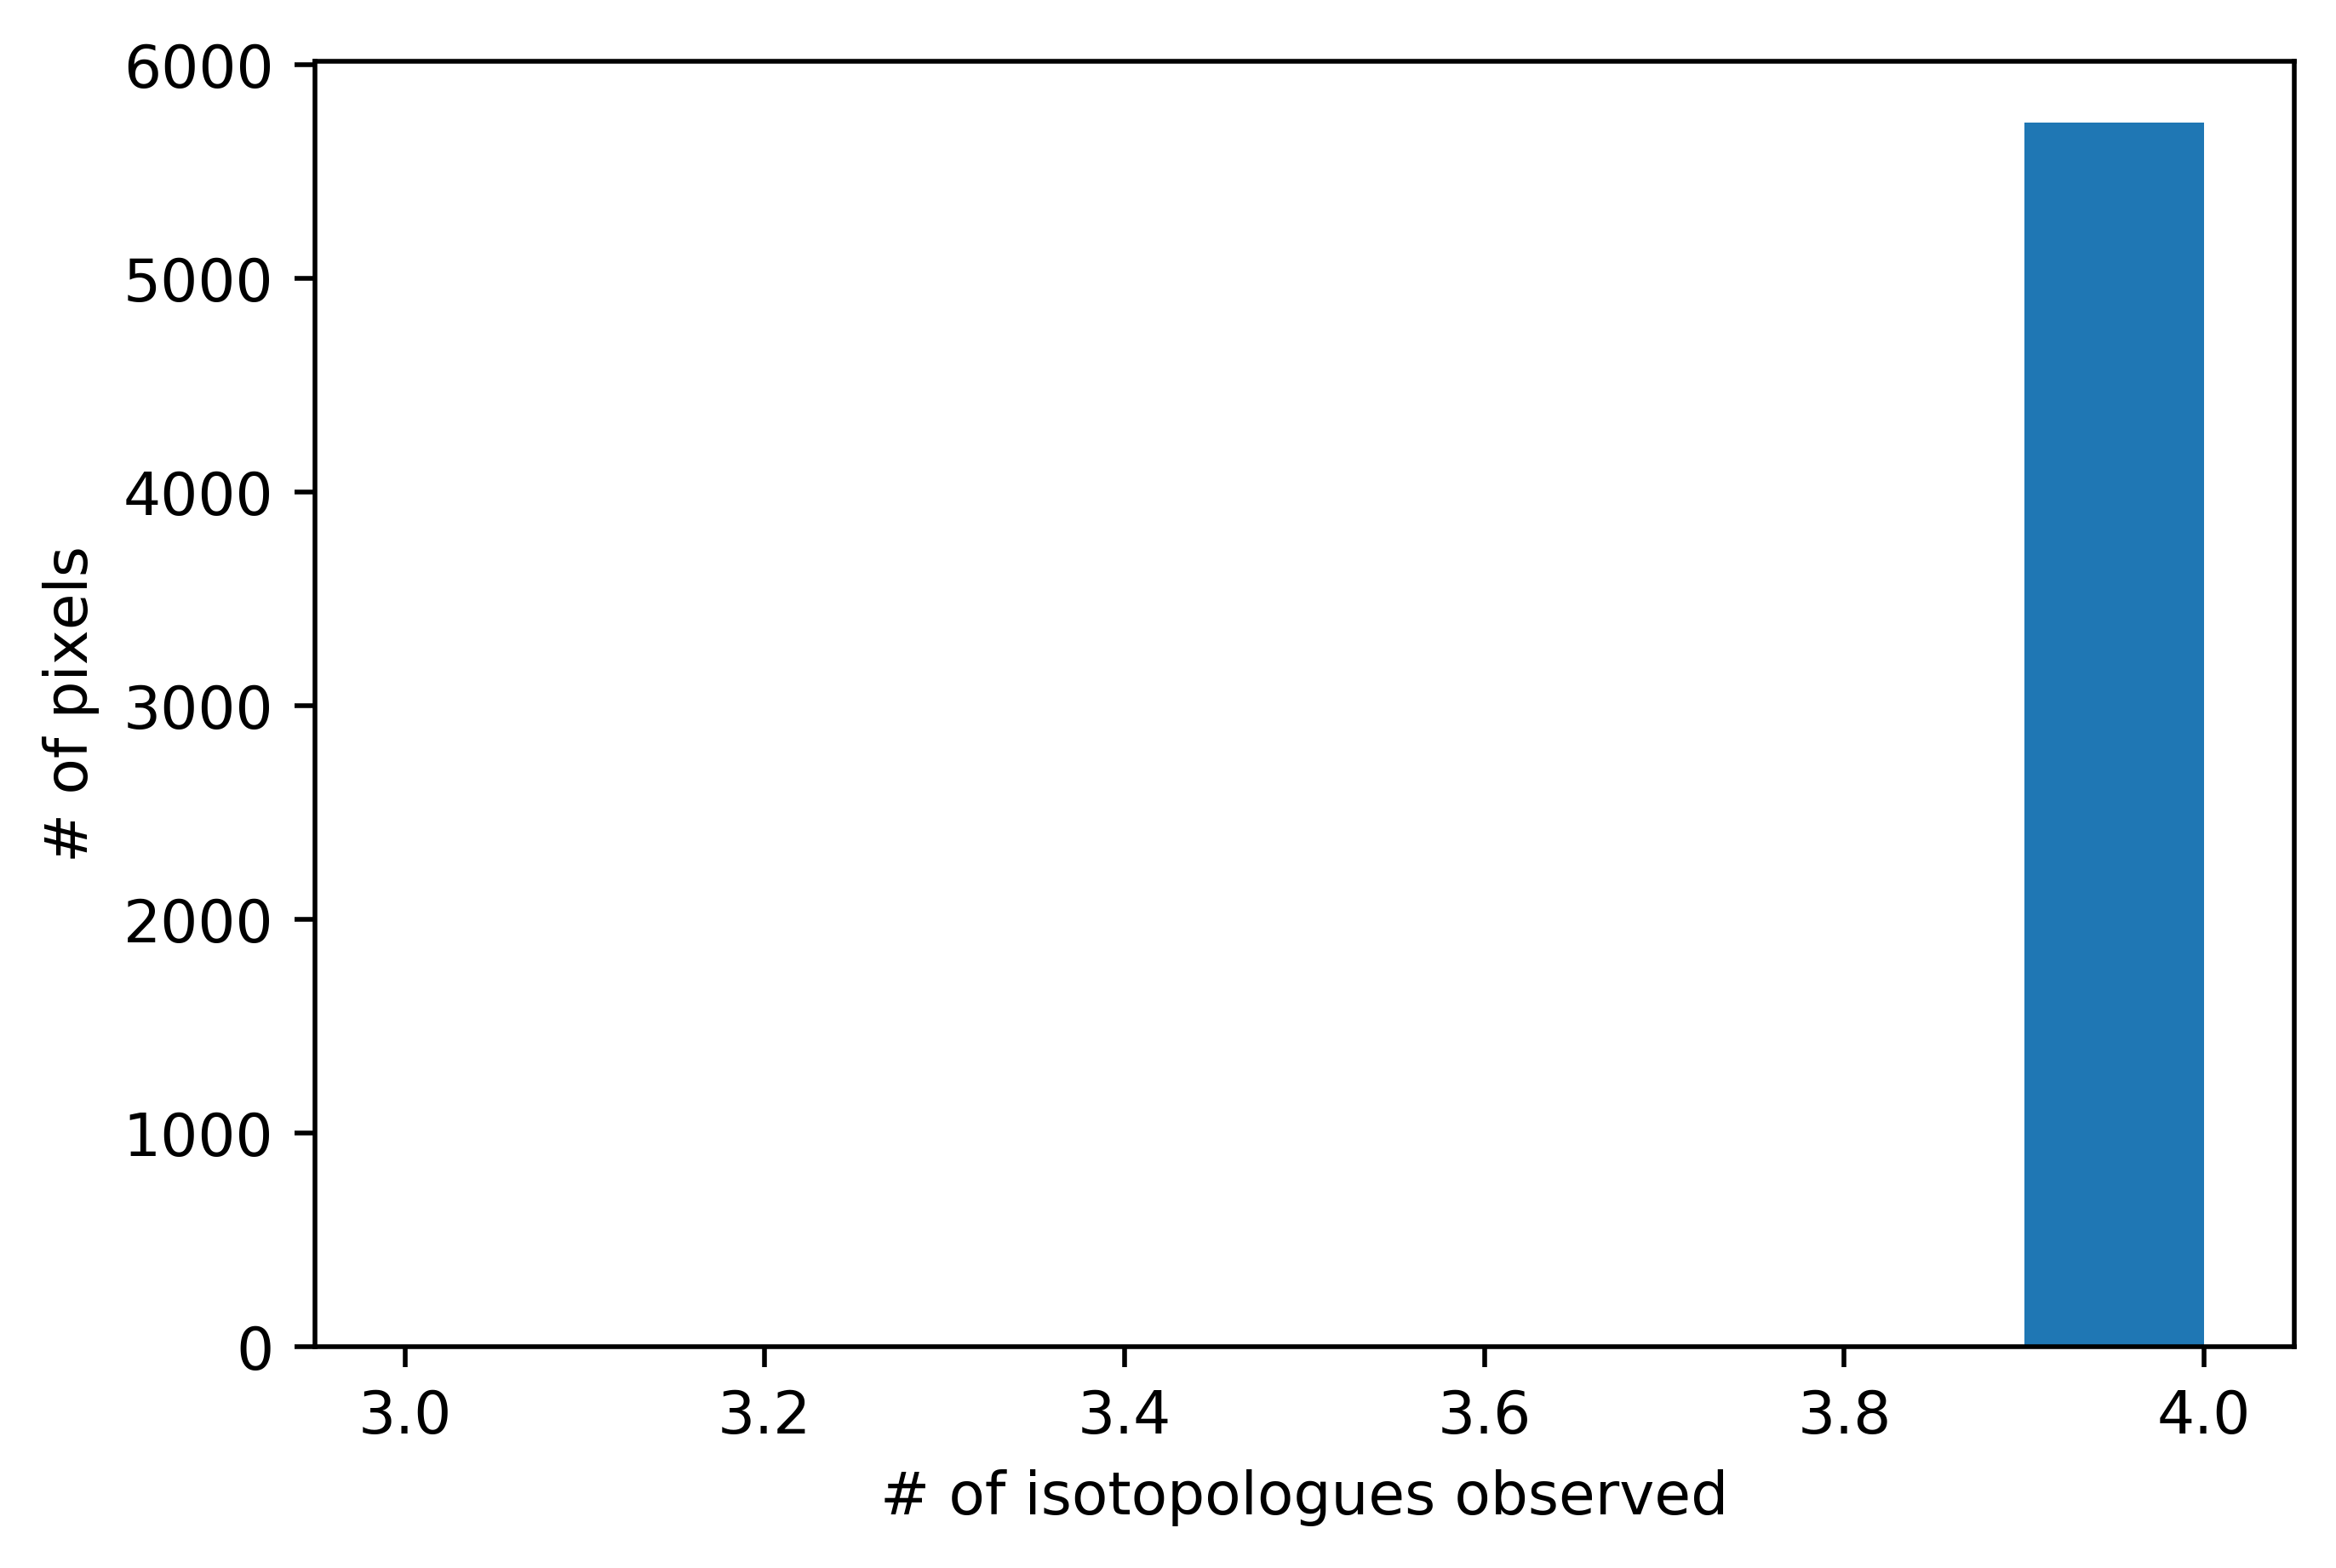

In [8]:
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
T = [0,0,1] #set initial tracer labeling

#create data structures to store output
fluxImageE = np.zeros((len(tensorFilt[palmitate_formula][0]),len(tensorFilt[palmitate_formula][0][0])))

#do pixel by pixel ISA
argList = []
coords = []

numFounds = []
P_consider = []
for r in range(len(tensorFilt[palmitate_formula][0])):
    for c in range(len(tensorFilt[palmitate_formula][0][0])):
        #get palmitate labeling
        P = tensorFilt[formula][:,r,c]

        goodInd = [x for x in range(len(P)) if P[x] > 0]

        #if not on background pixel
        if imageBoundary[r,c] > .5 and goodPixels[r,c] > .5:
            #fit palmitate ISA
            numFounds.append(len(goodInd))
            lab = [fluxImageT0[r,c],fluxImageT1[r,c],fluxImageT2[r,c]]
            argList.append((lab,N,P,ISA_funcs[formula],goodInd,[.5,.5]))#np.random.random(1)))
            coords.append((r,c))
            P_consider.append(P)


plt.hist(numFounds)
plt.xlabel("# of isotopologues observed")
plt.ylabel("# of pixels")

if __name__ == "__main__":
    pool = Pool(num_cores)
    results = pool.starmap(helper.ISAFit_knownT,argList)
    pool.close()
    pool.join()
    

for (e,_,_,err,P_pred),(r,c),P_true in zip(results,coords,P_consider):
    #save results in data structures
    if e > -.0001 and e < 1.1:
        errs.append(err)
        P_preds.append(P_pred)
        P_trues.append(P_true)
        fluxImageE[r,c] = e

    else:
        print(e)
        errors.append(P_true)

T (mean) =  [0.30002582 0.09055611 0.60941806]


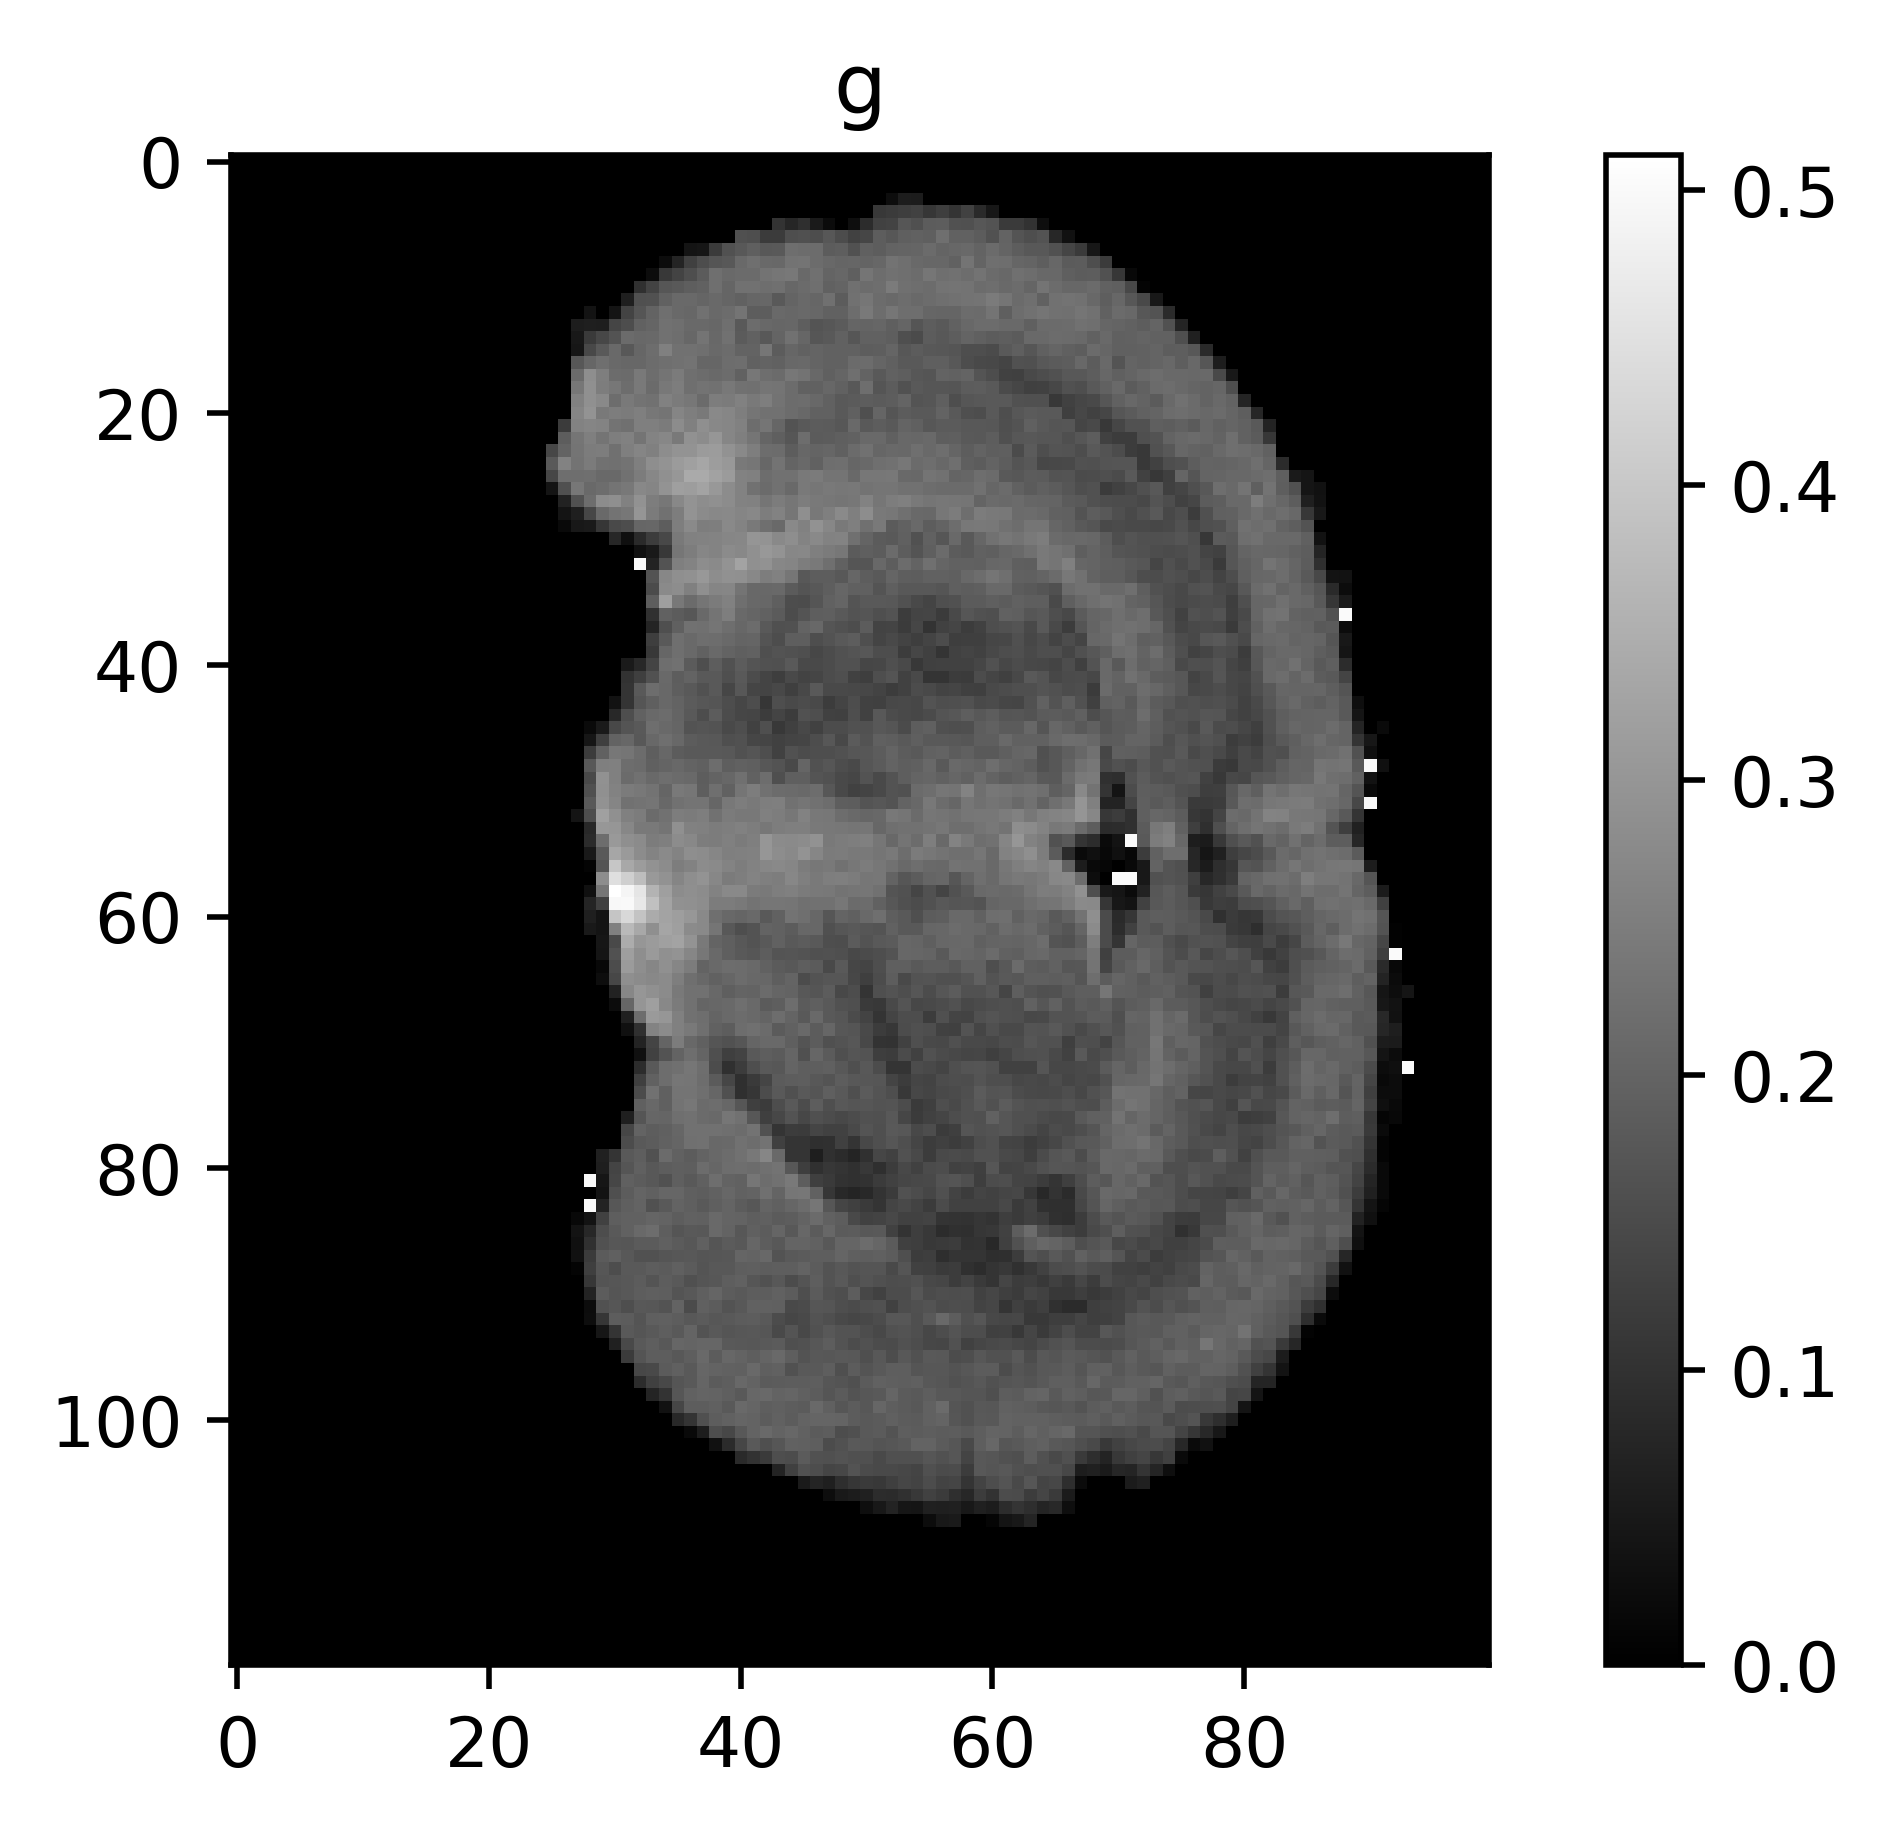

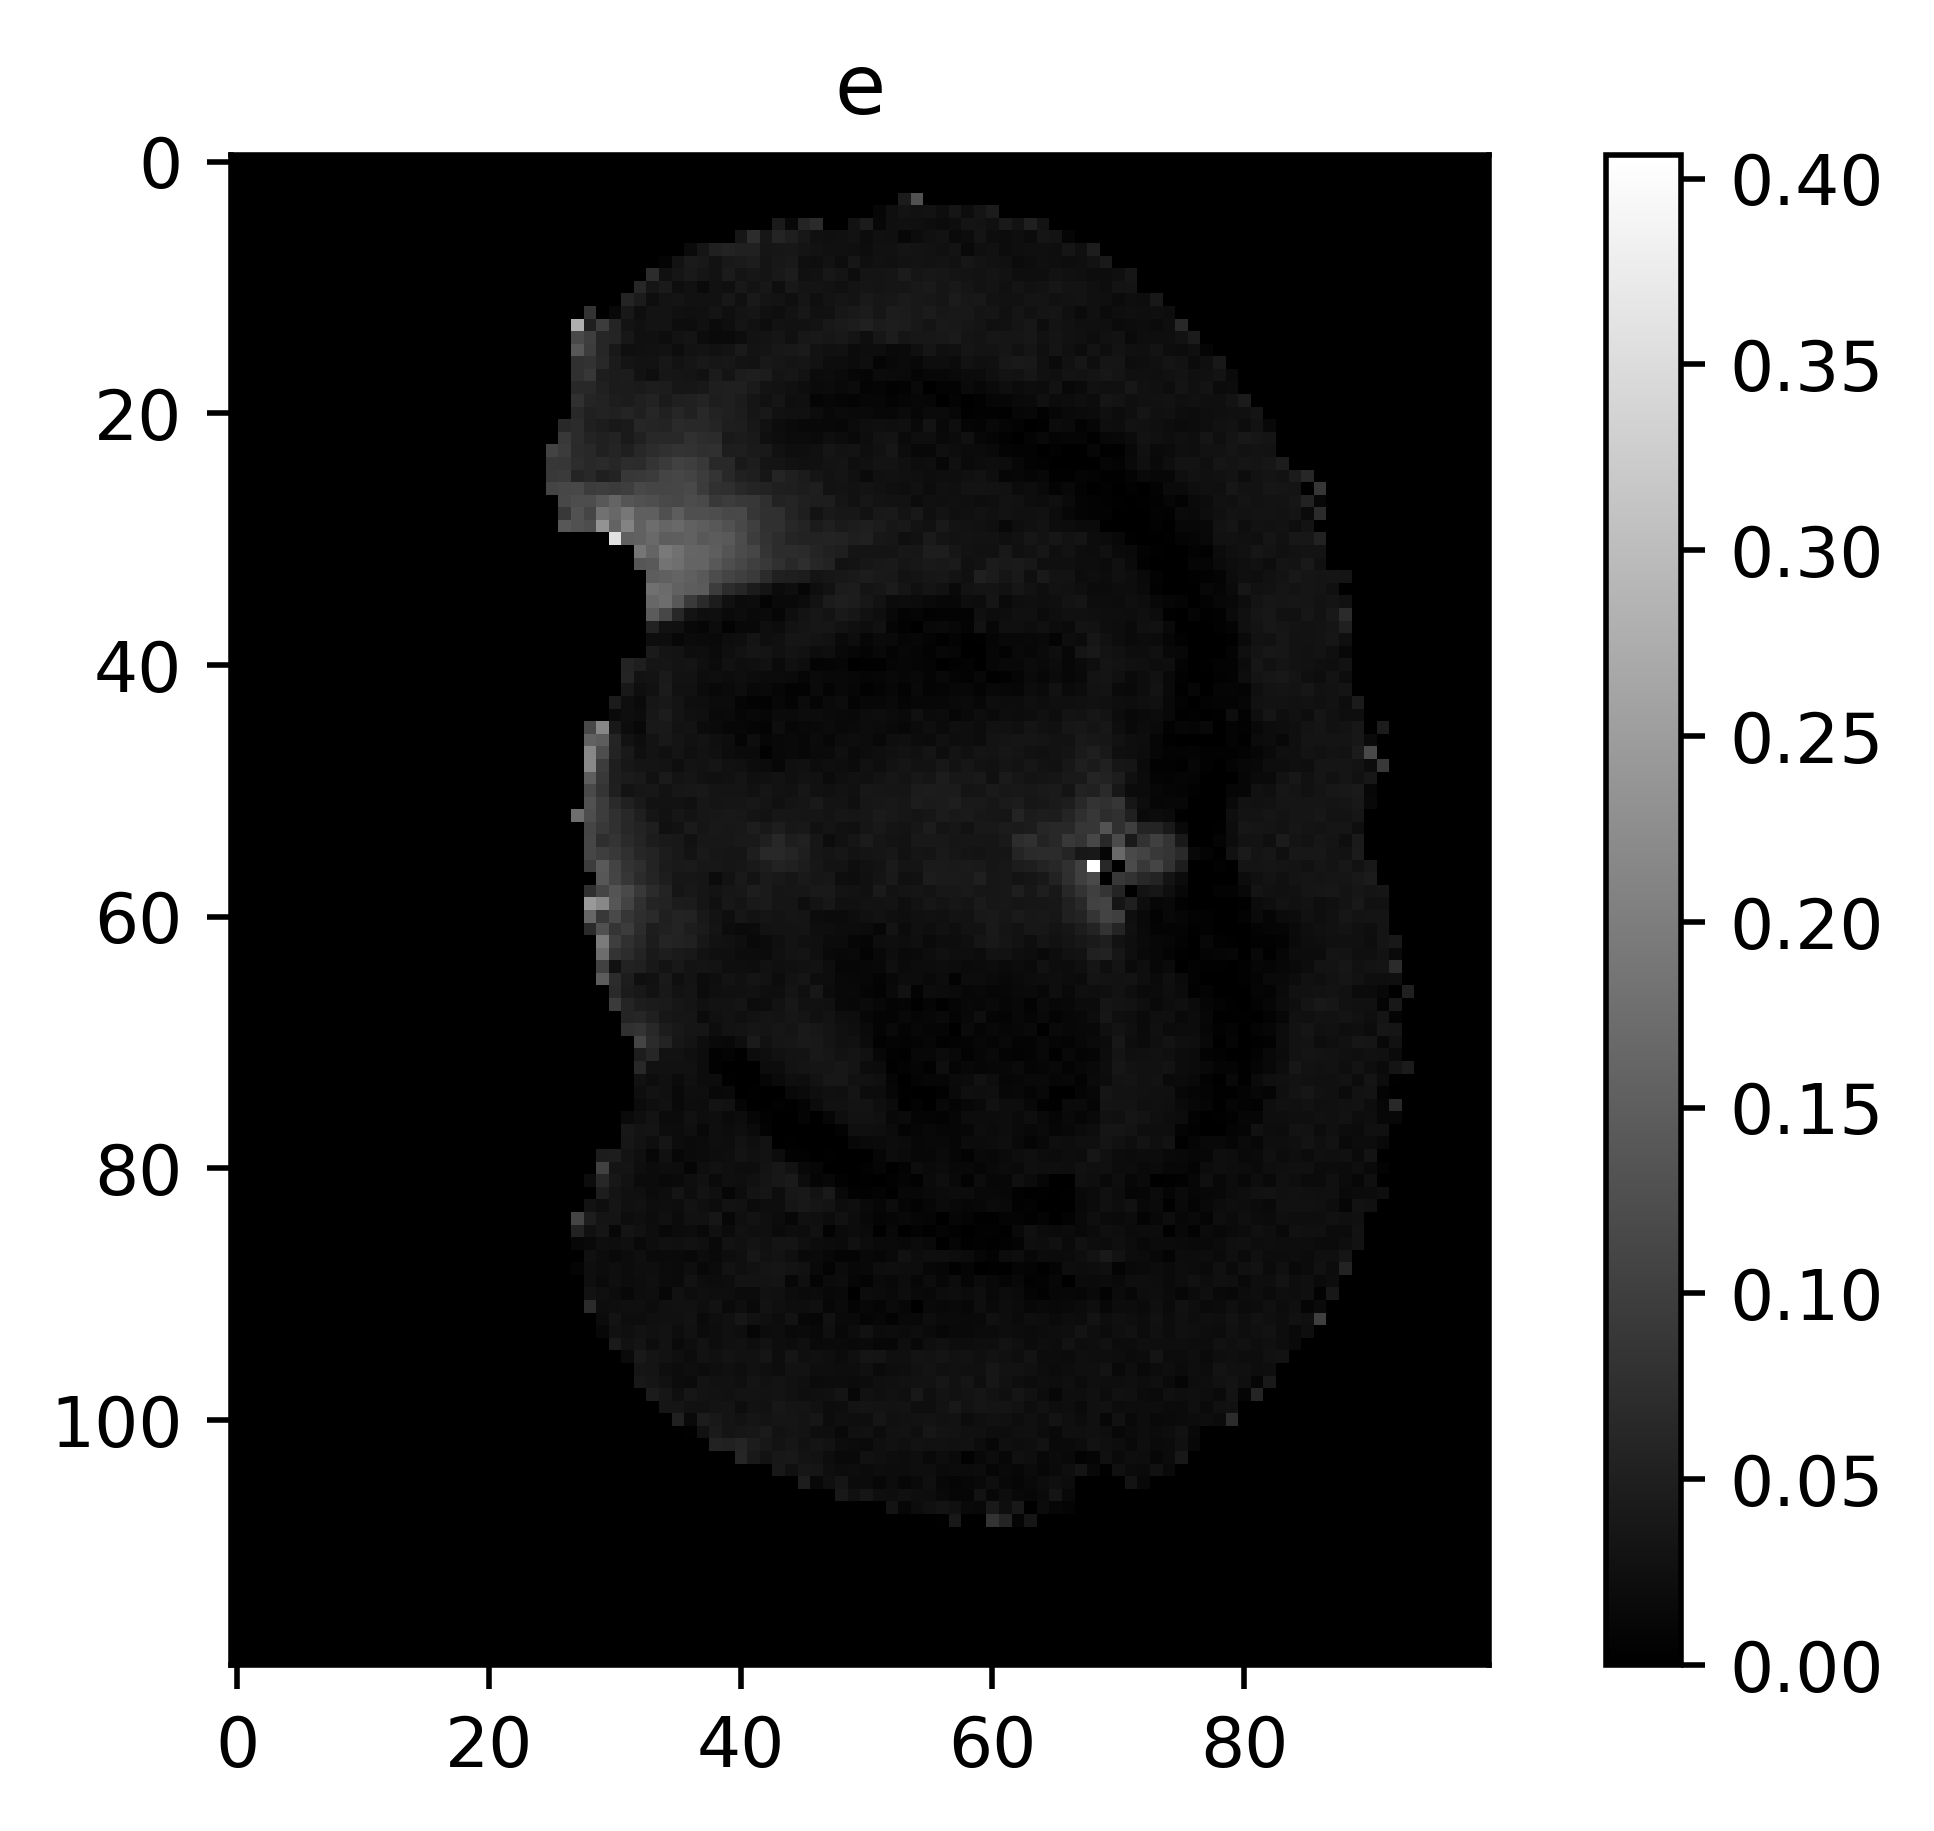

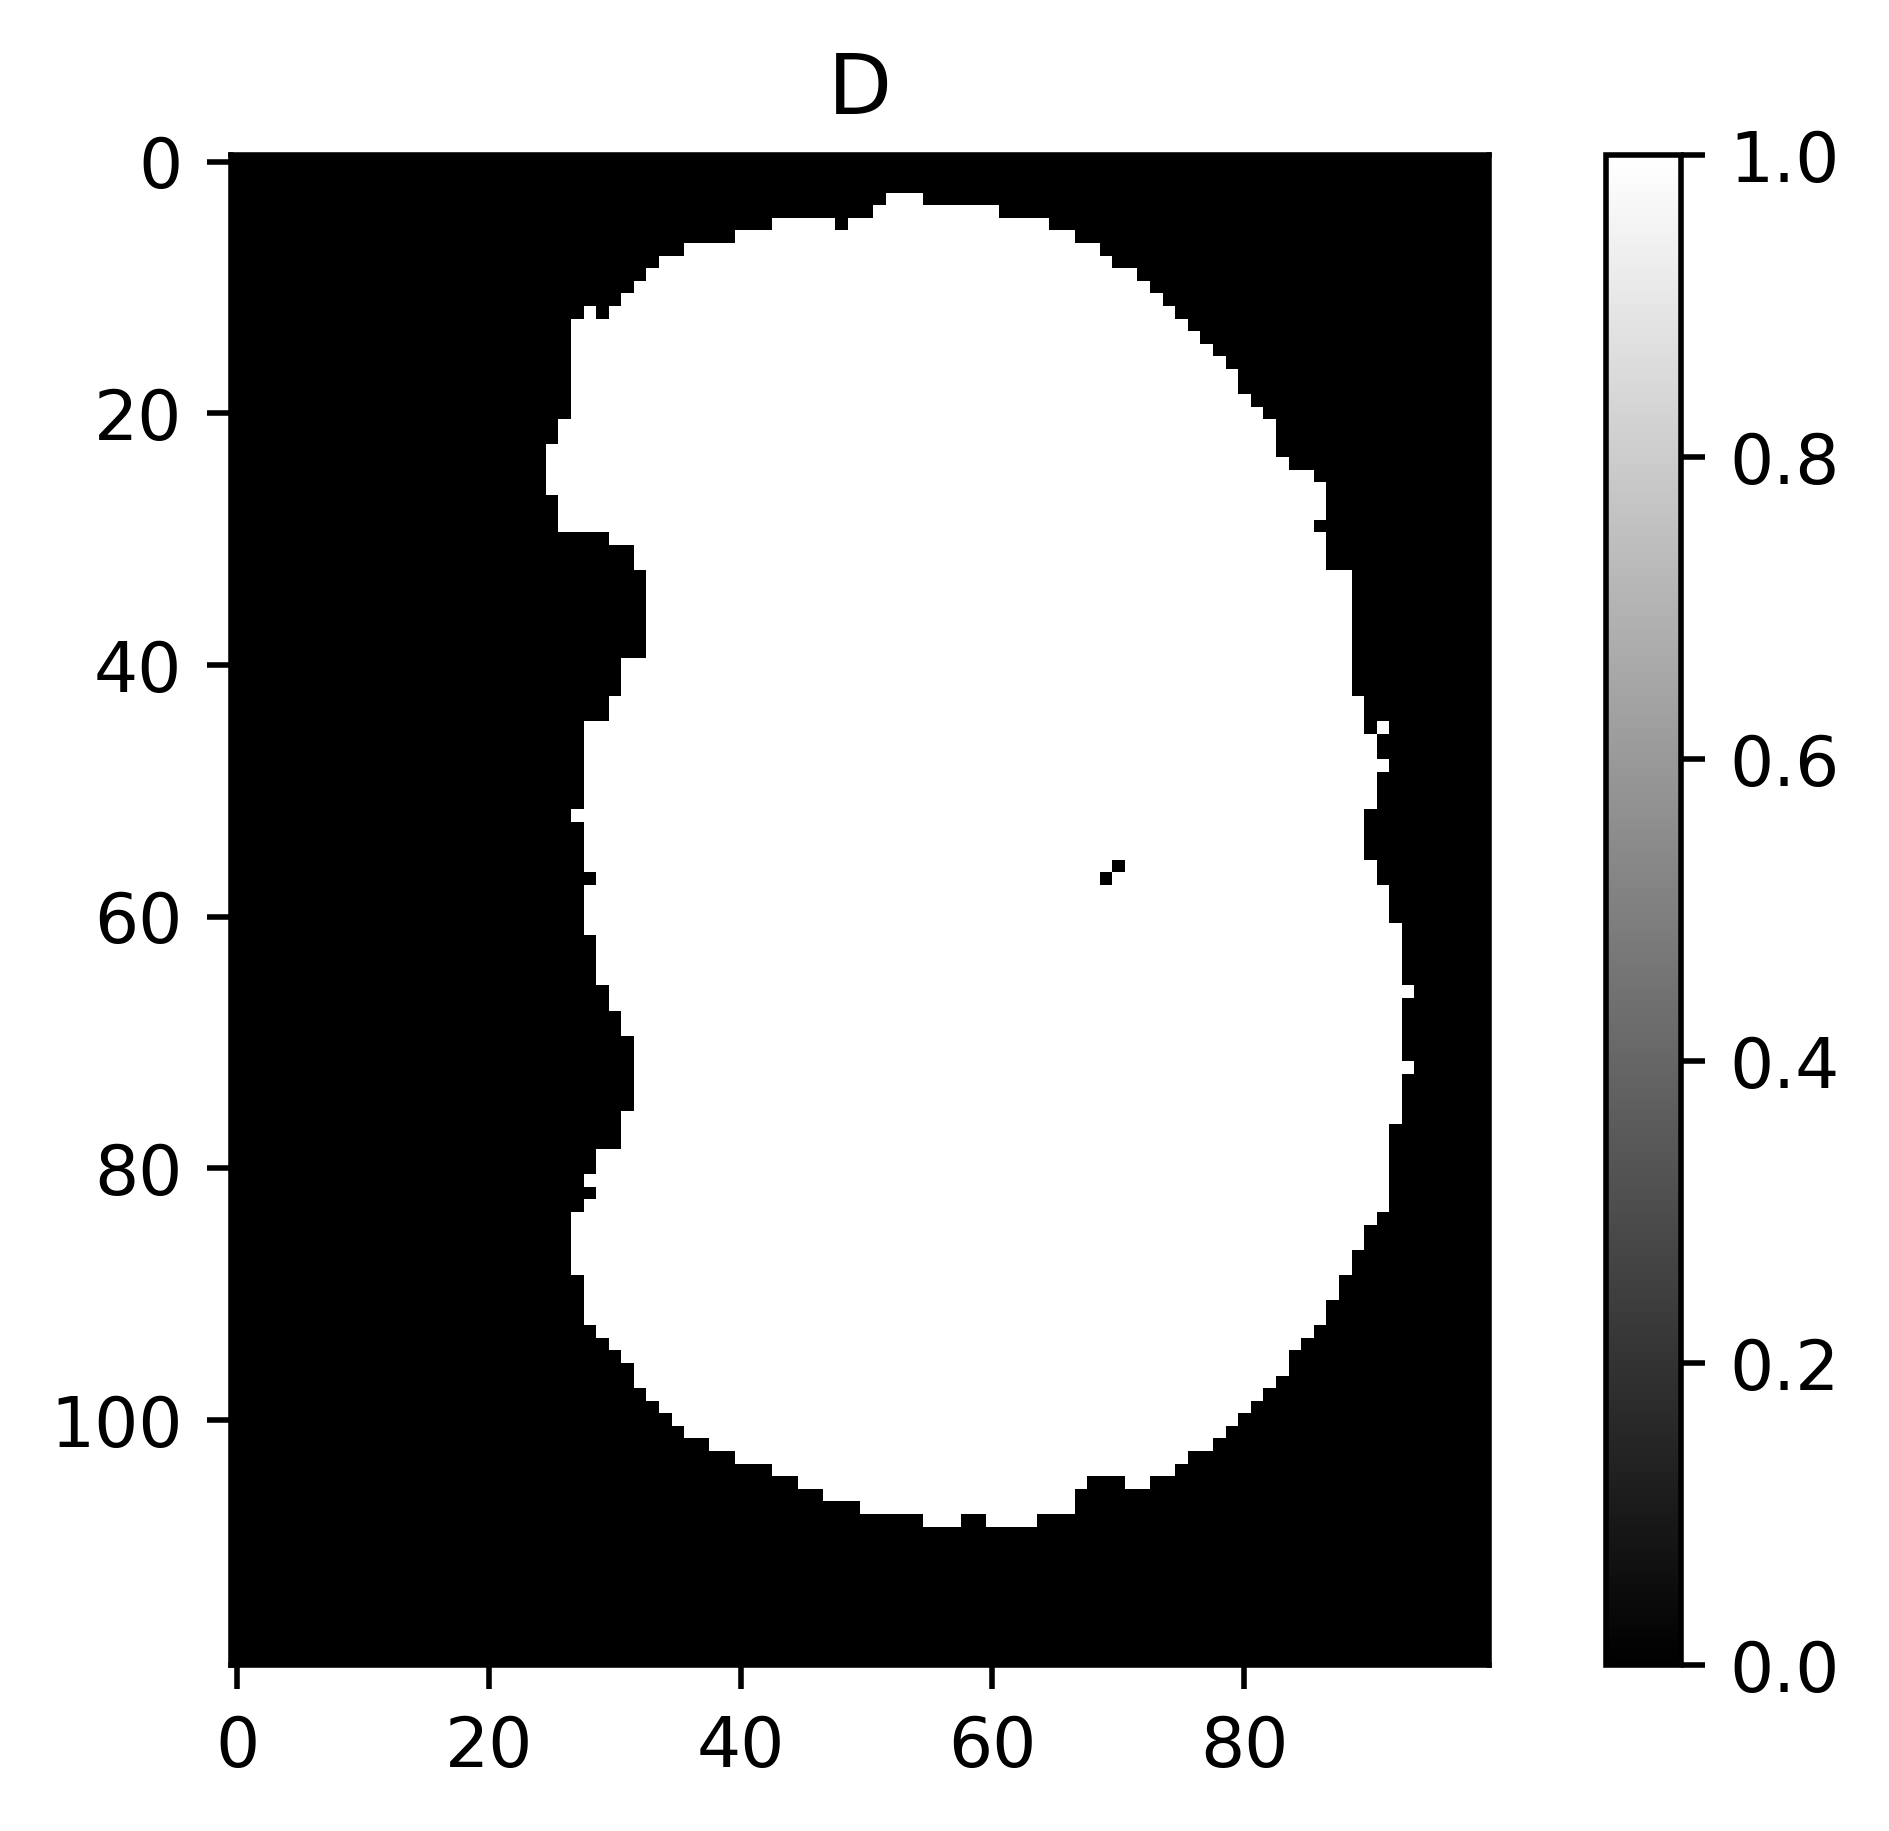

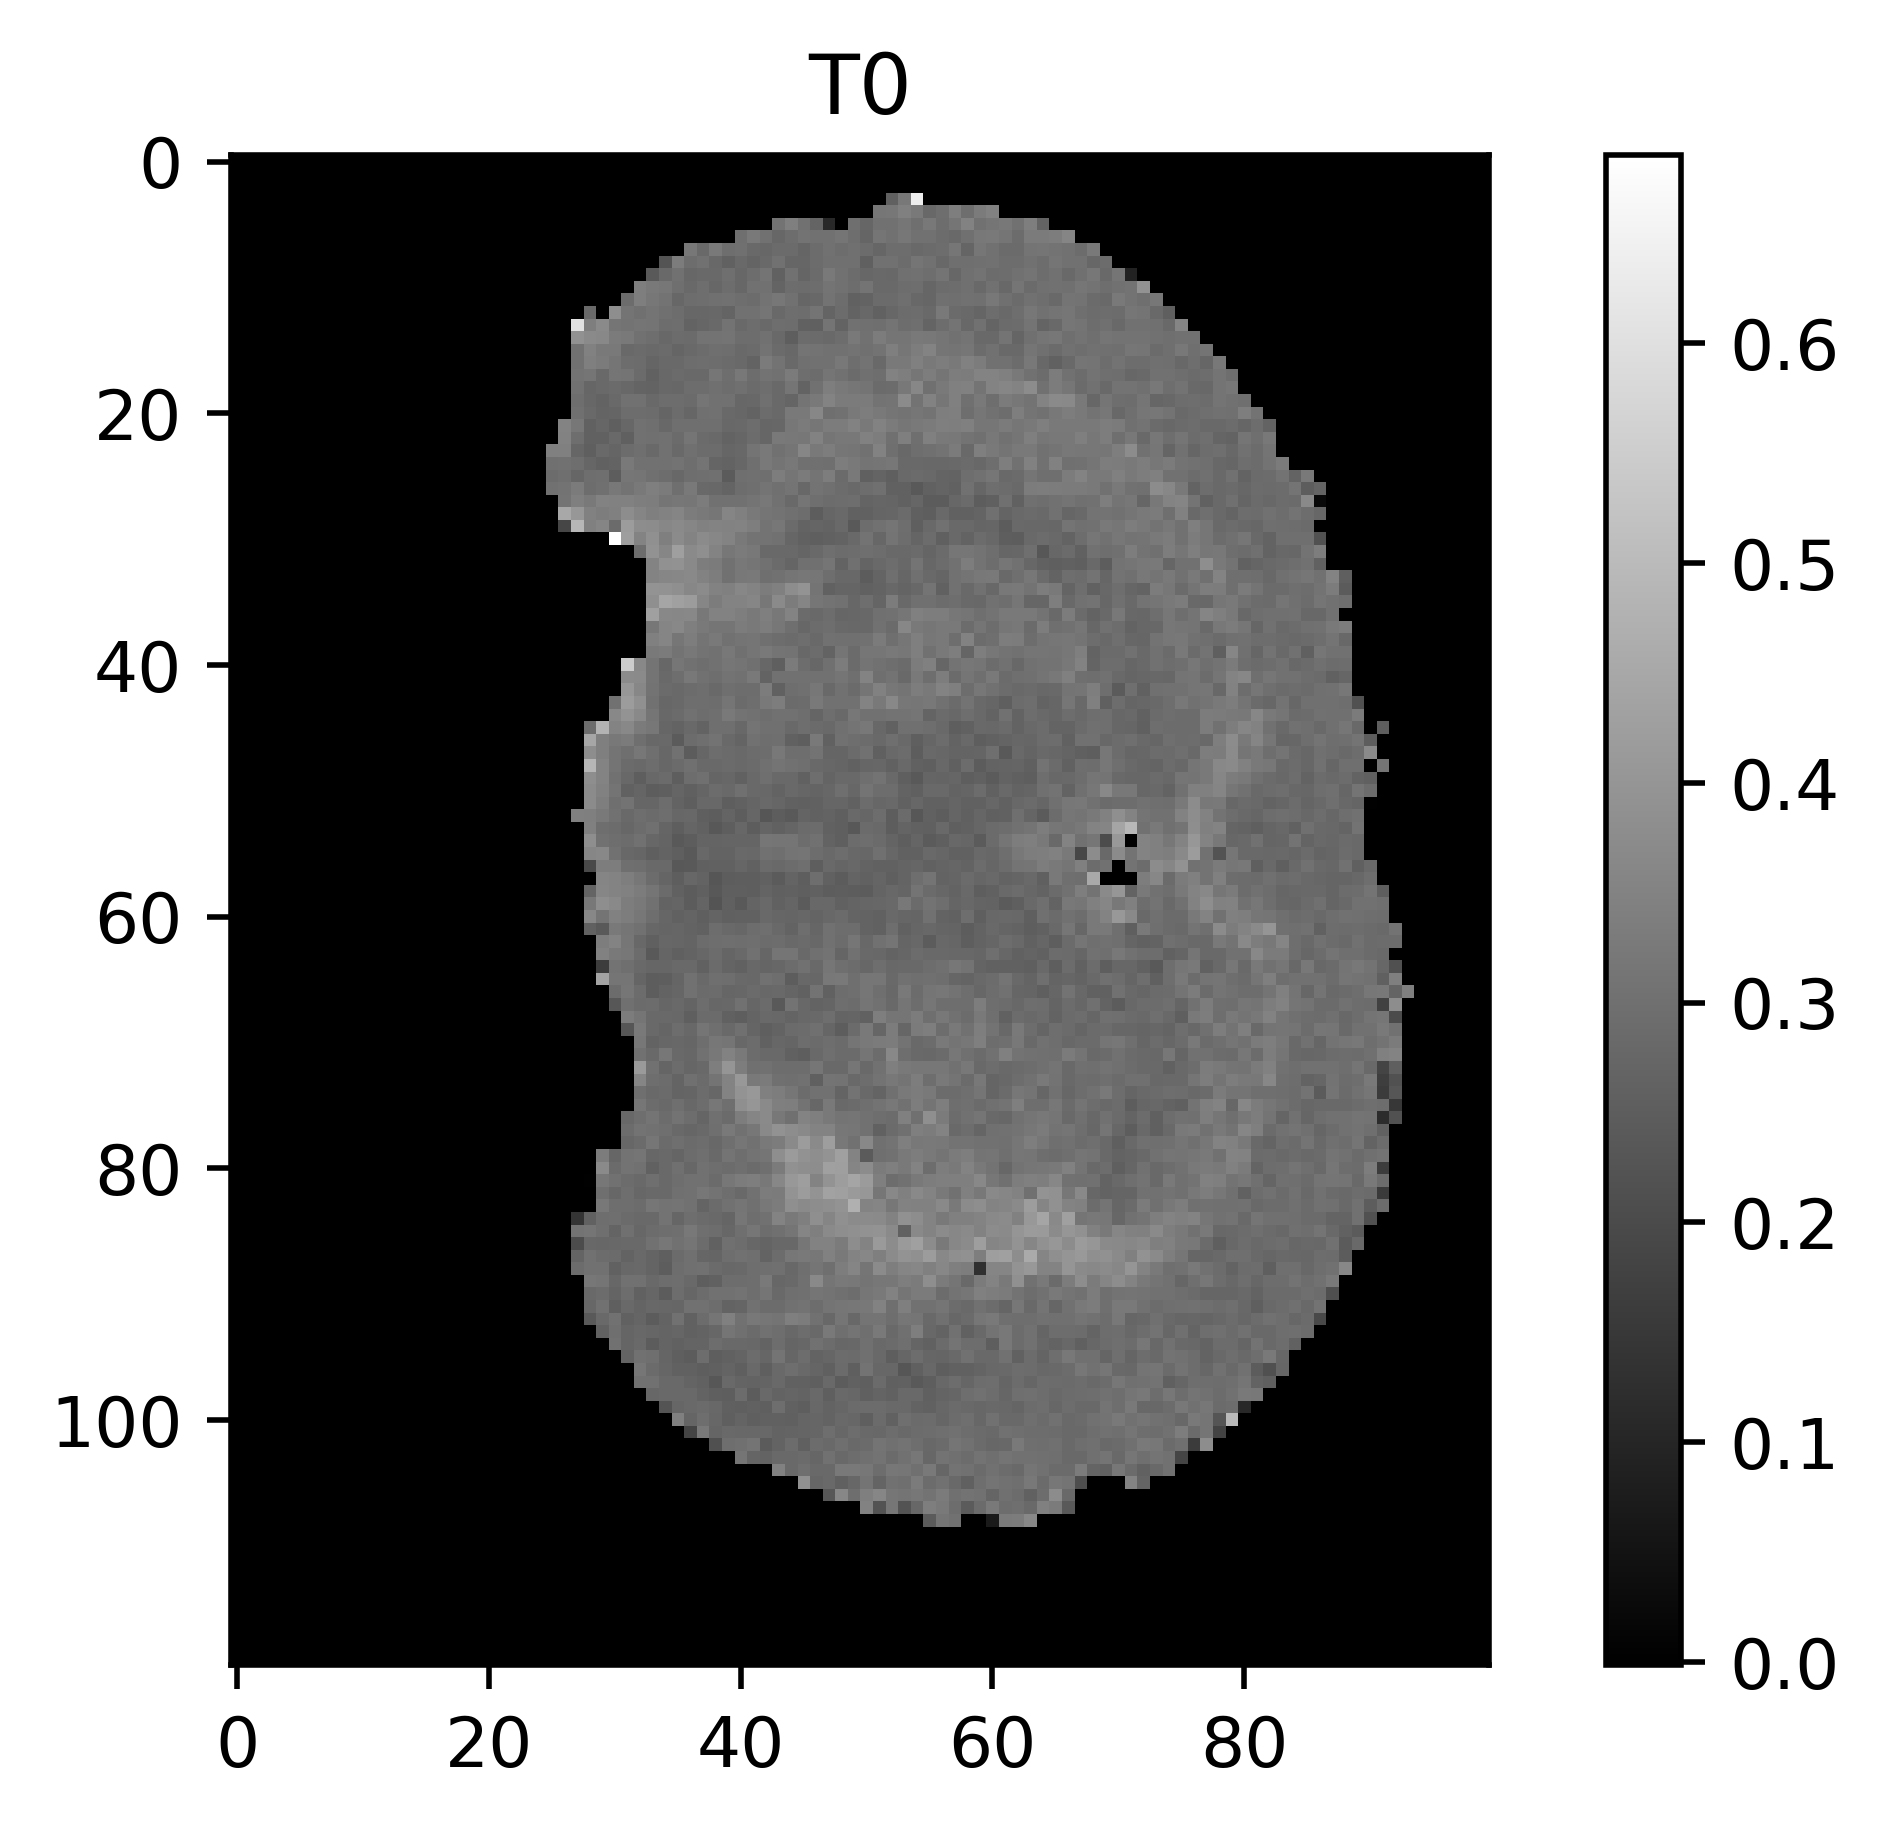

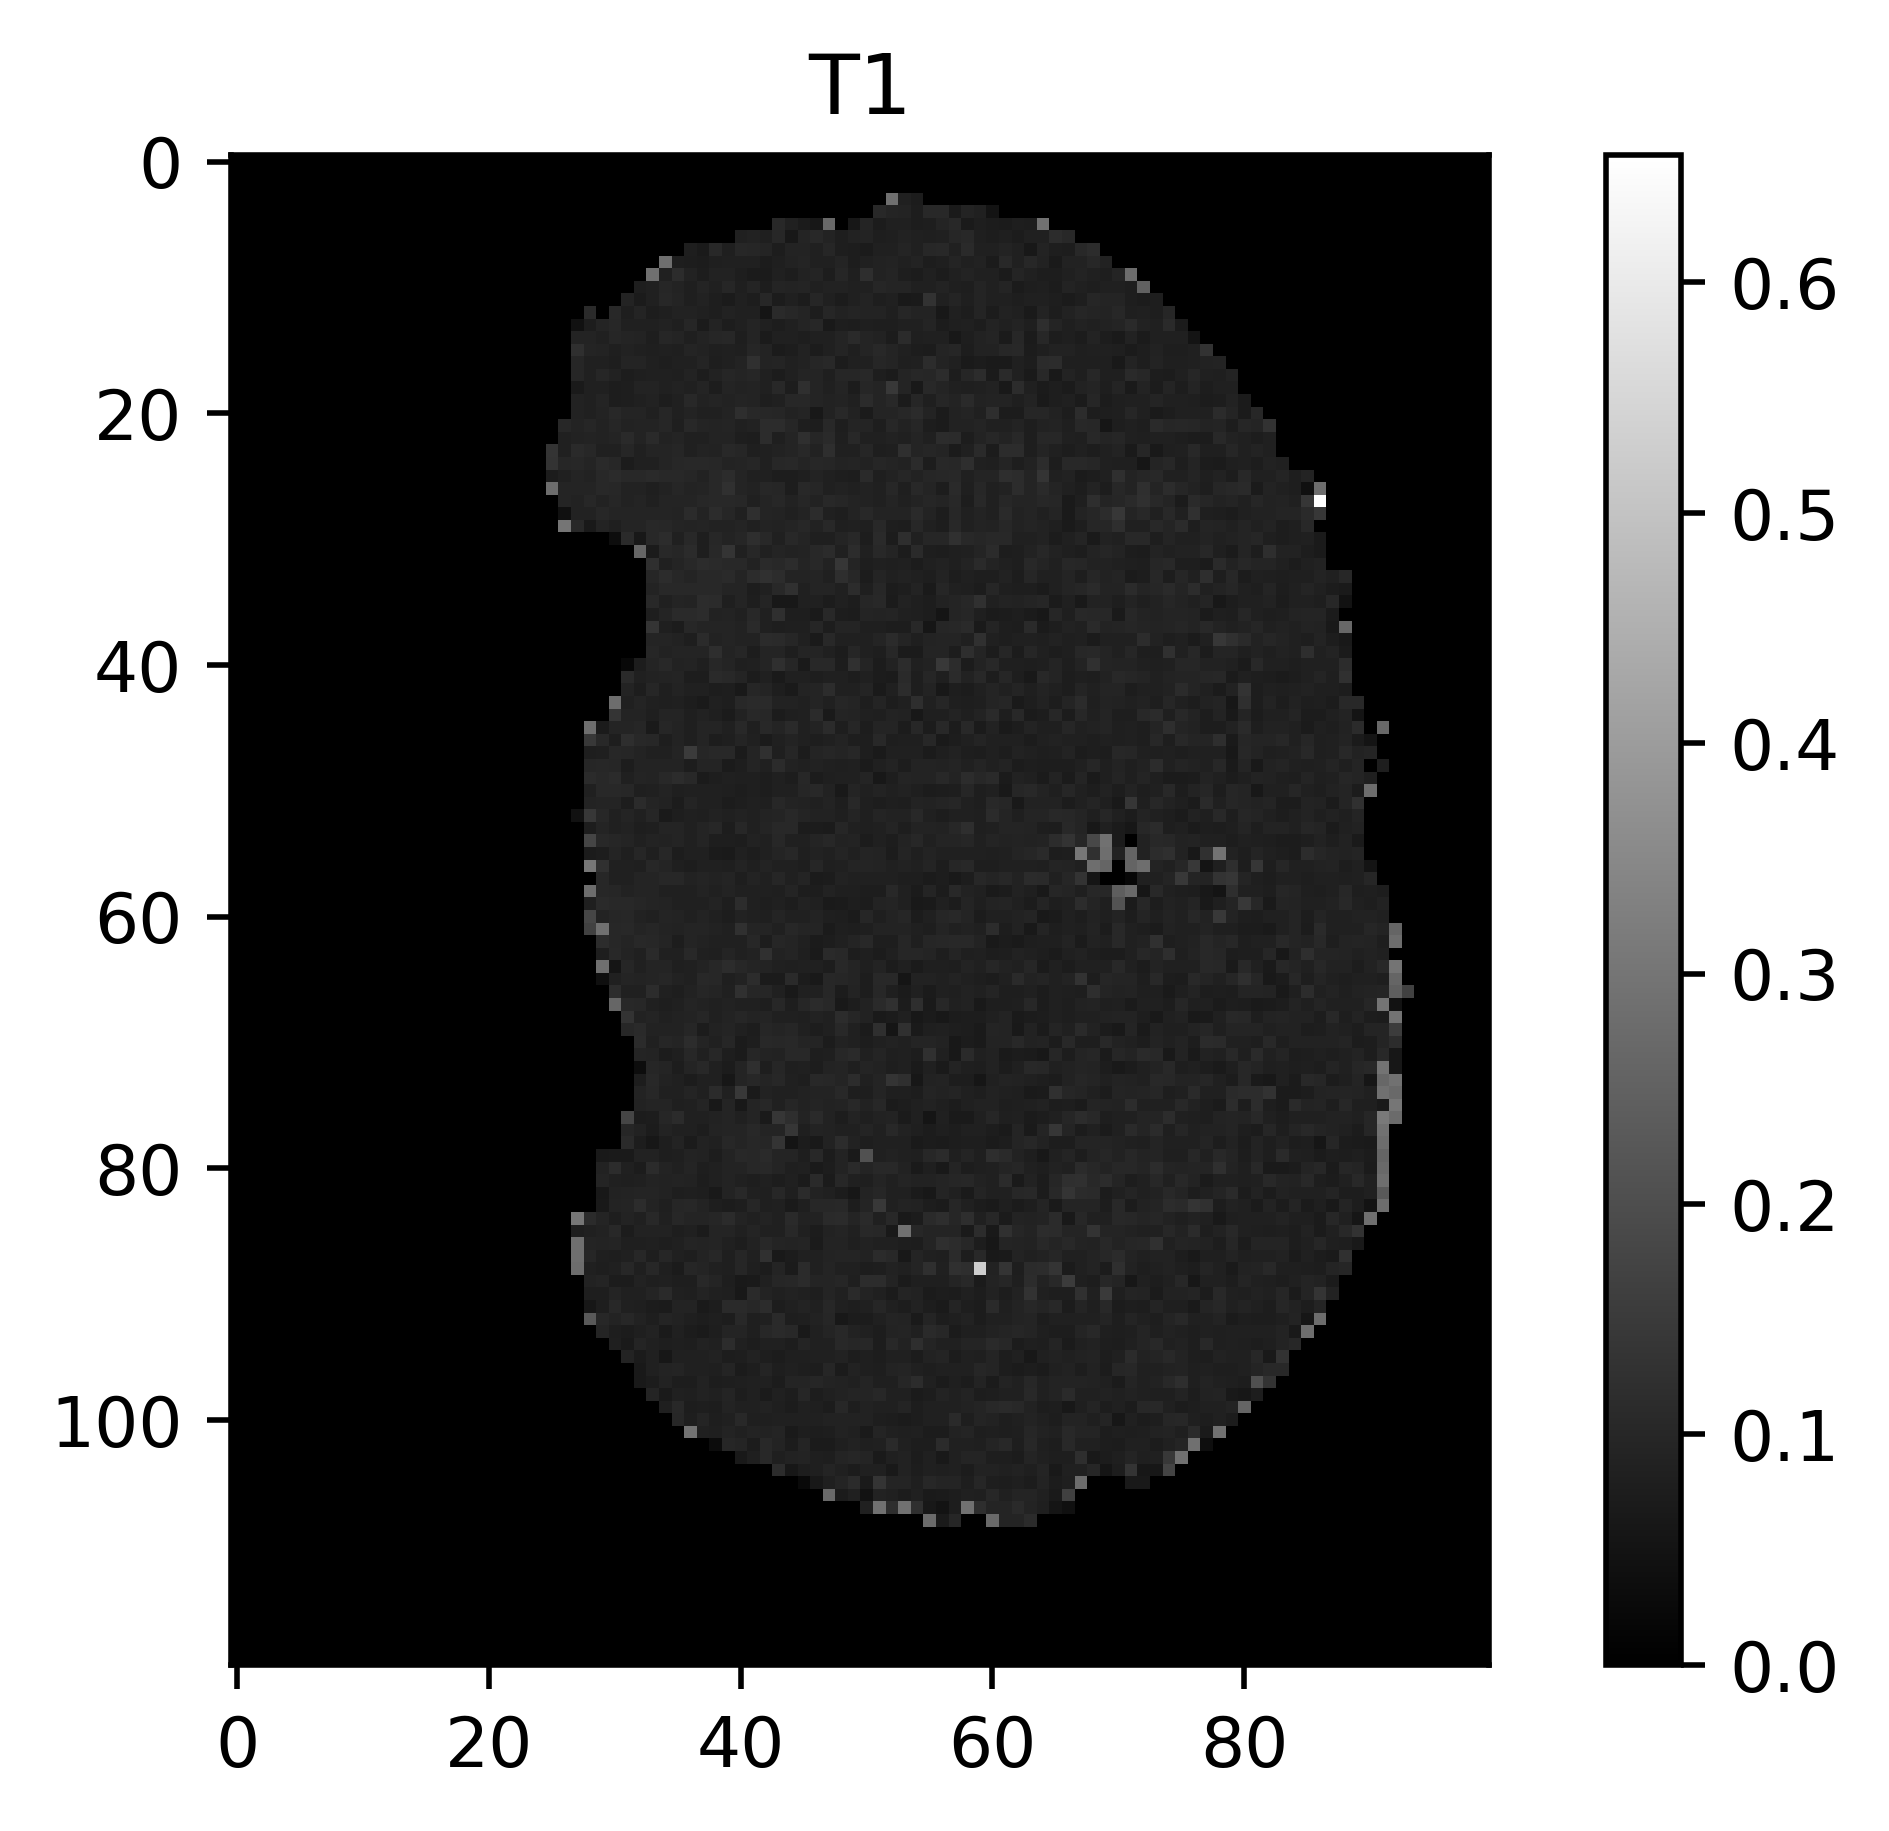

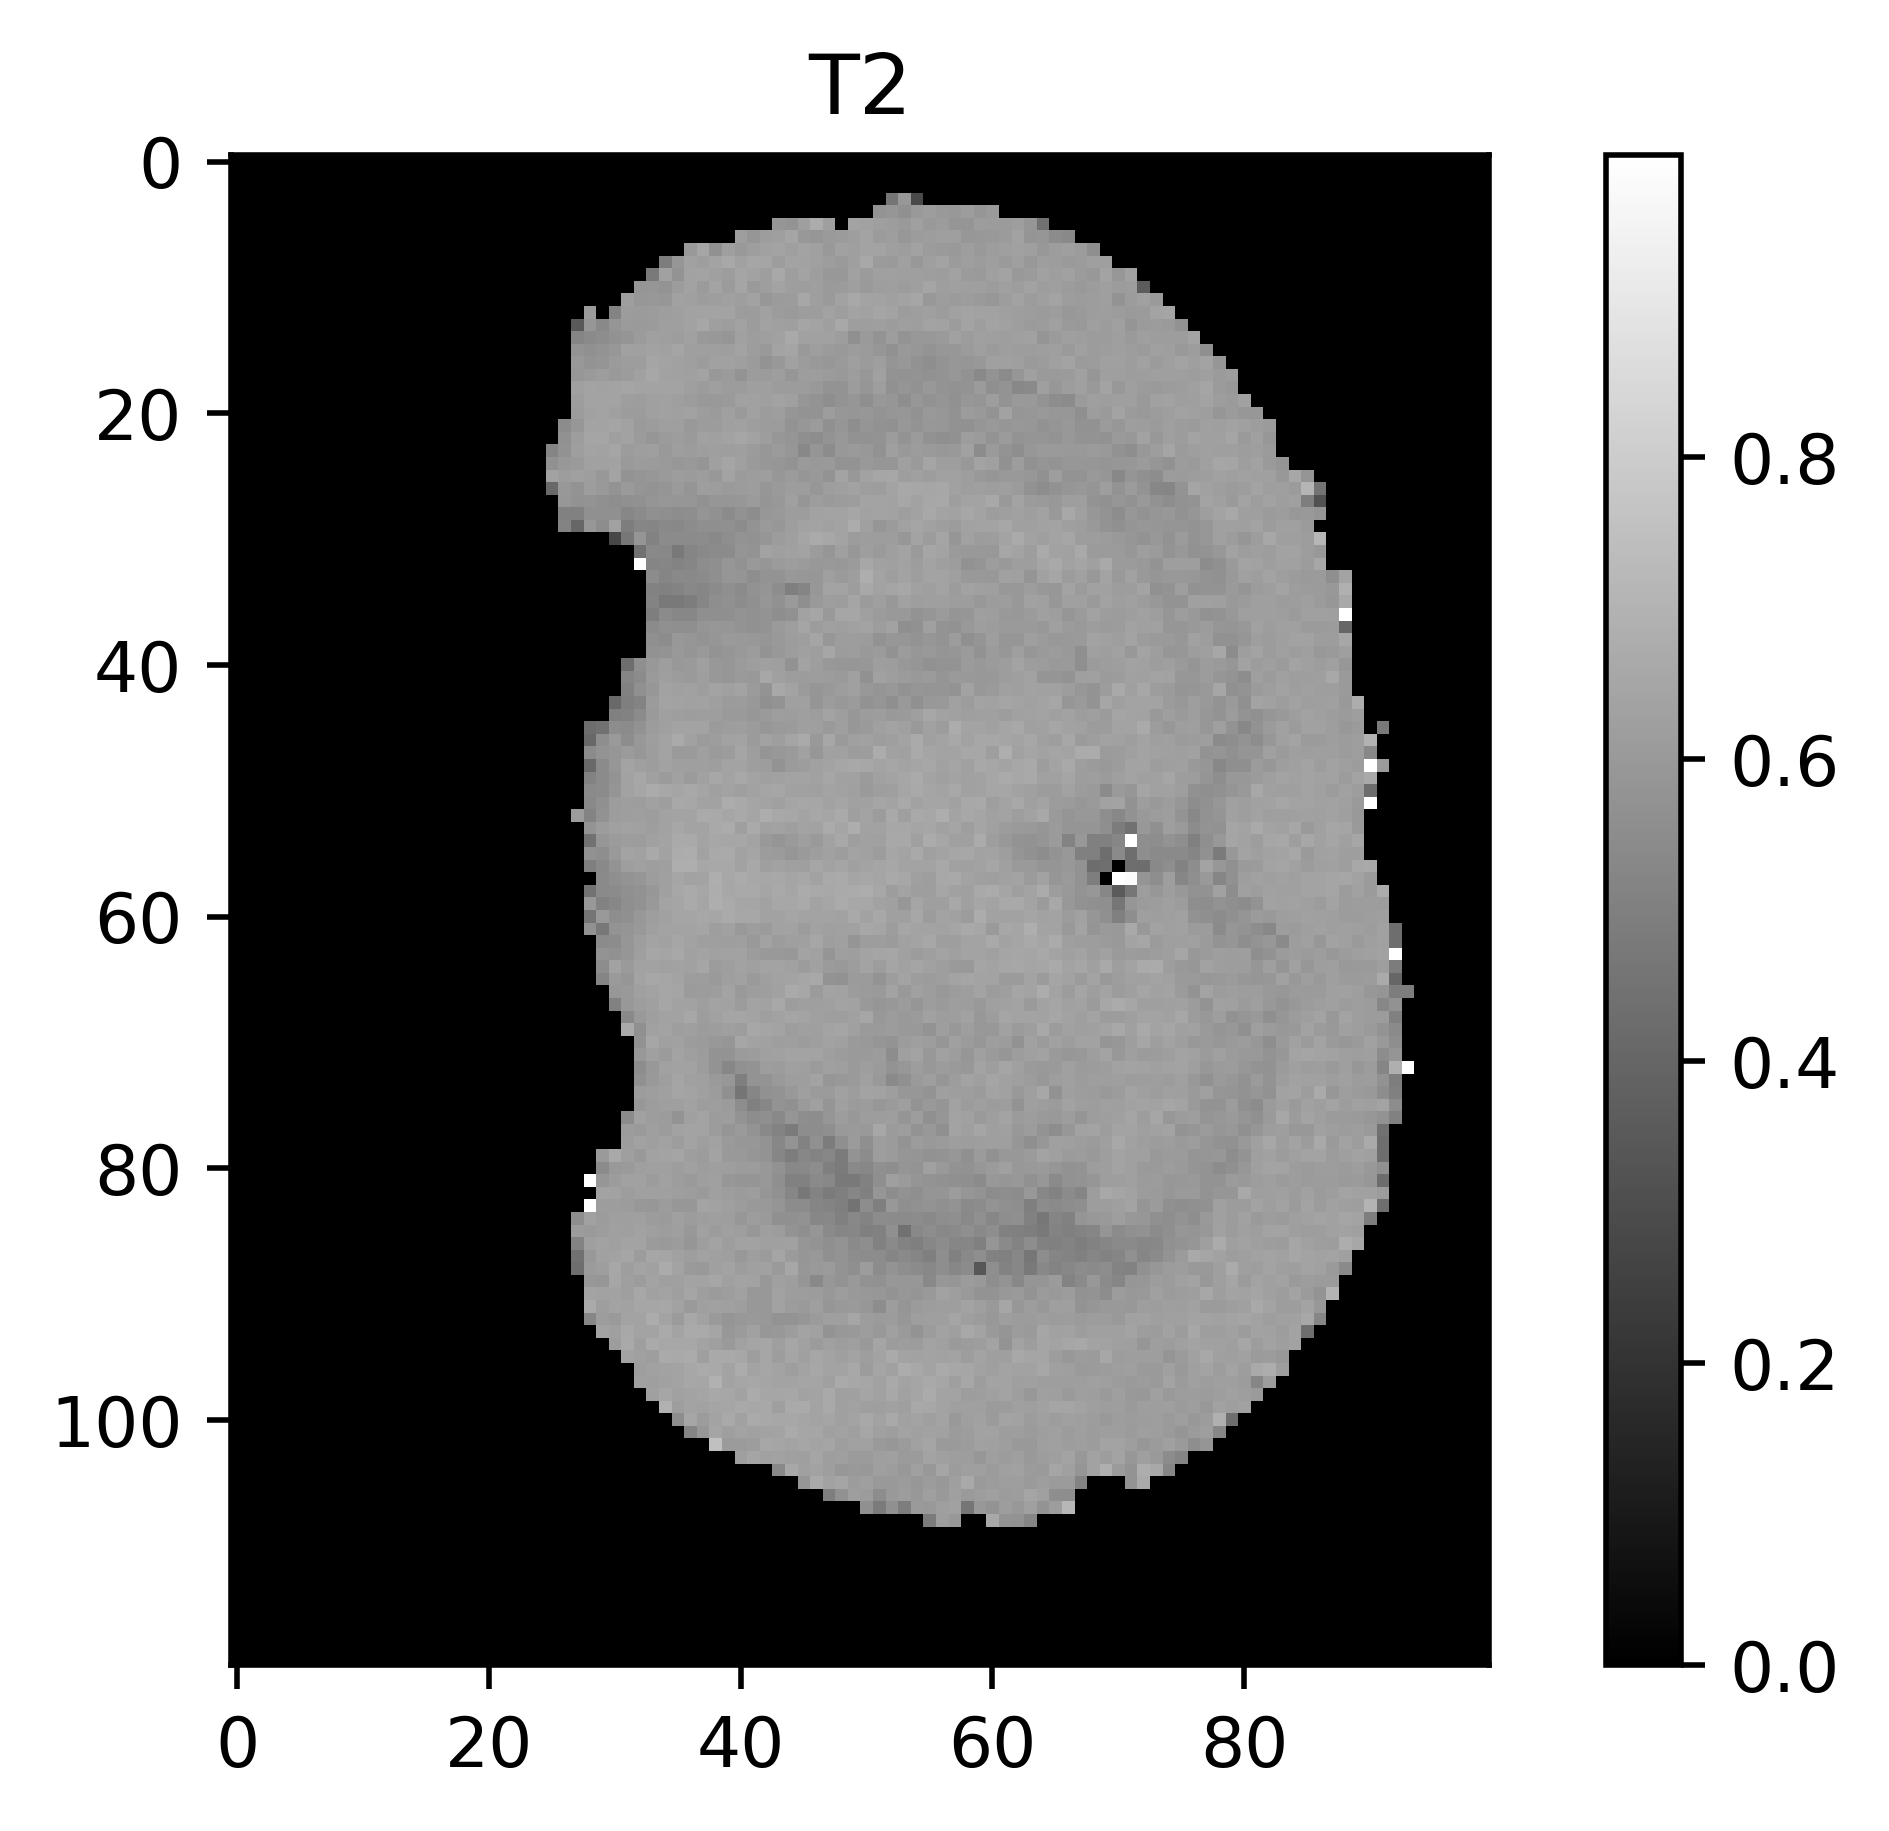

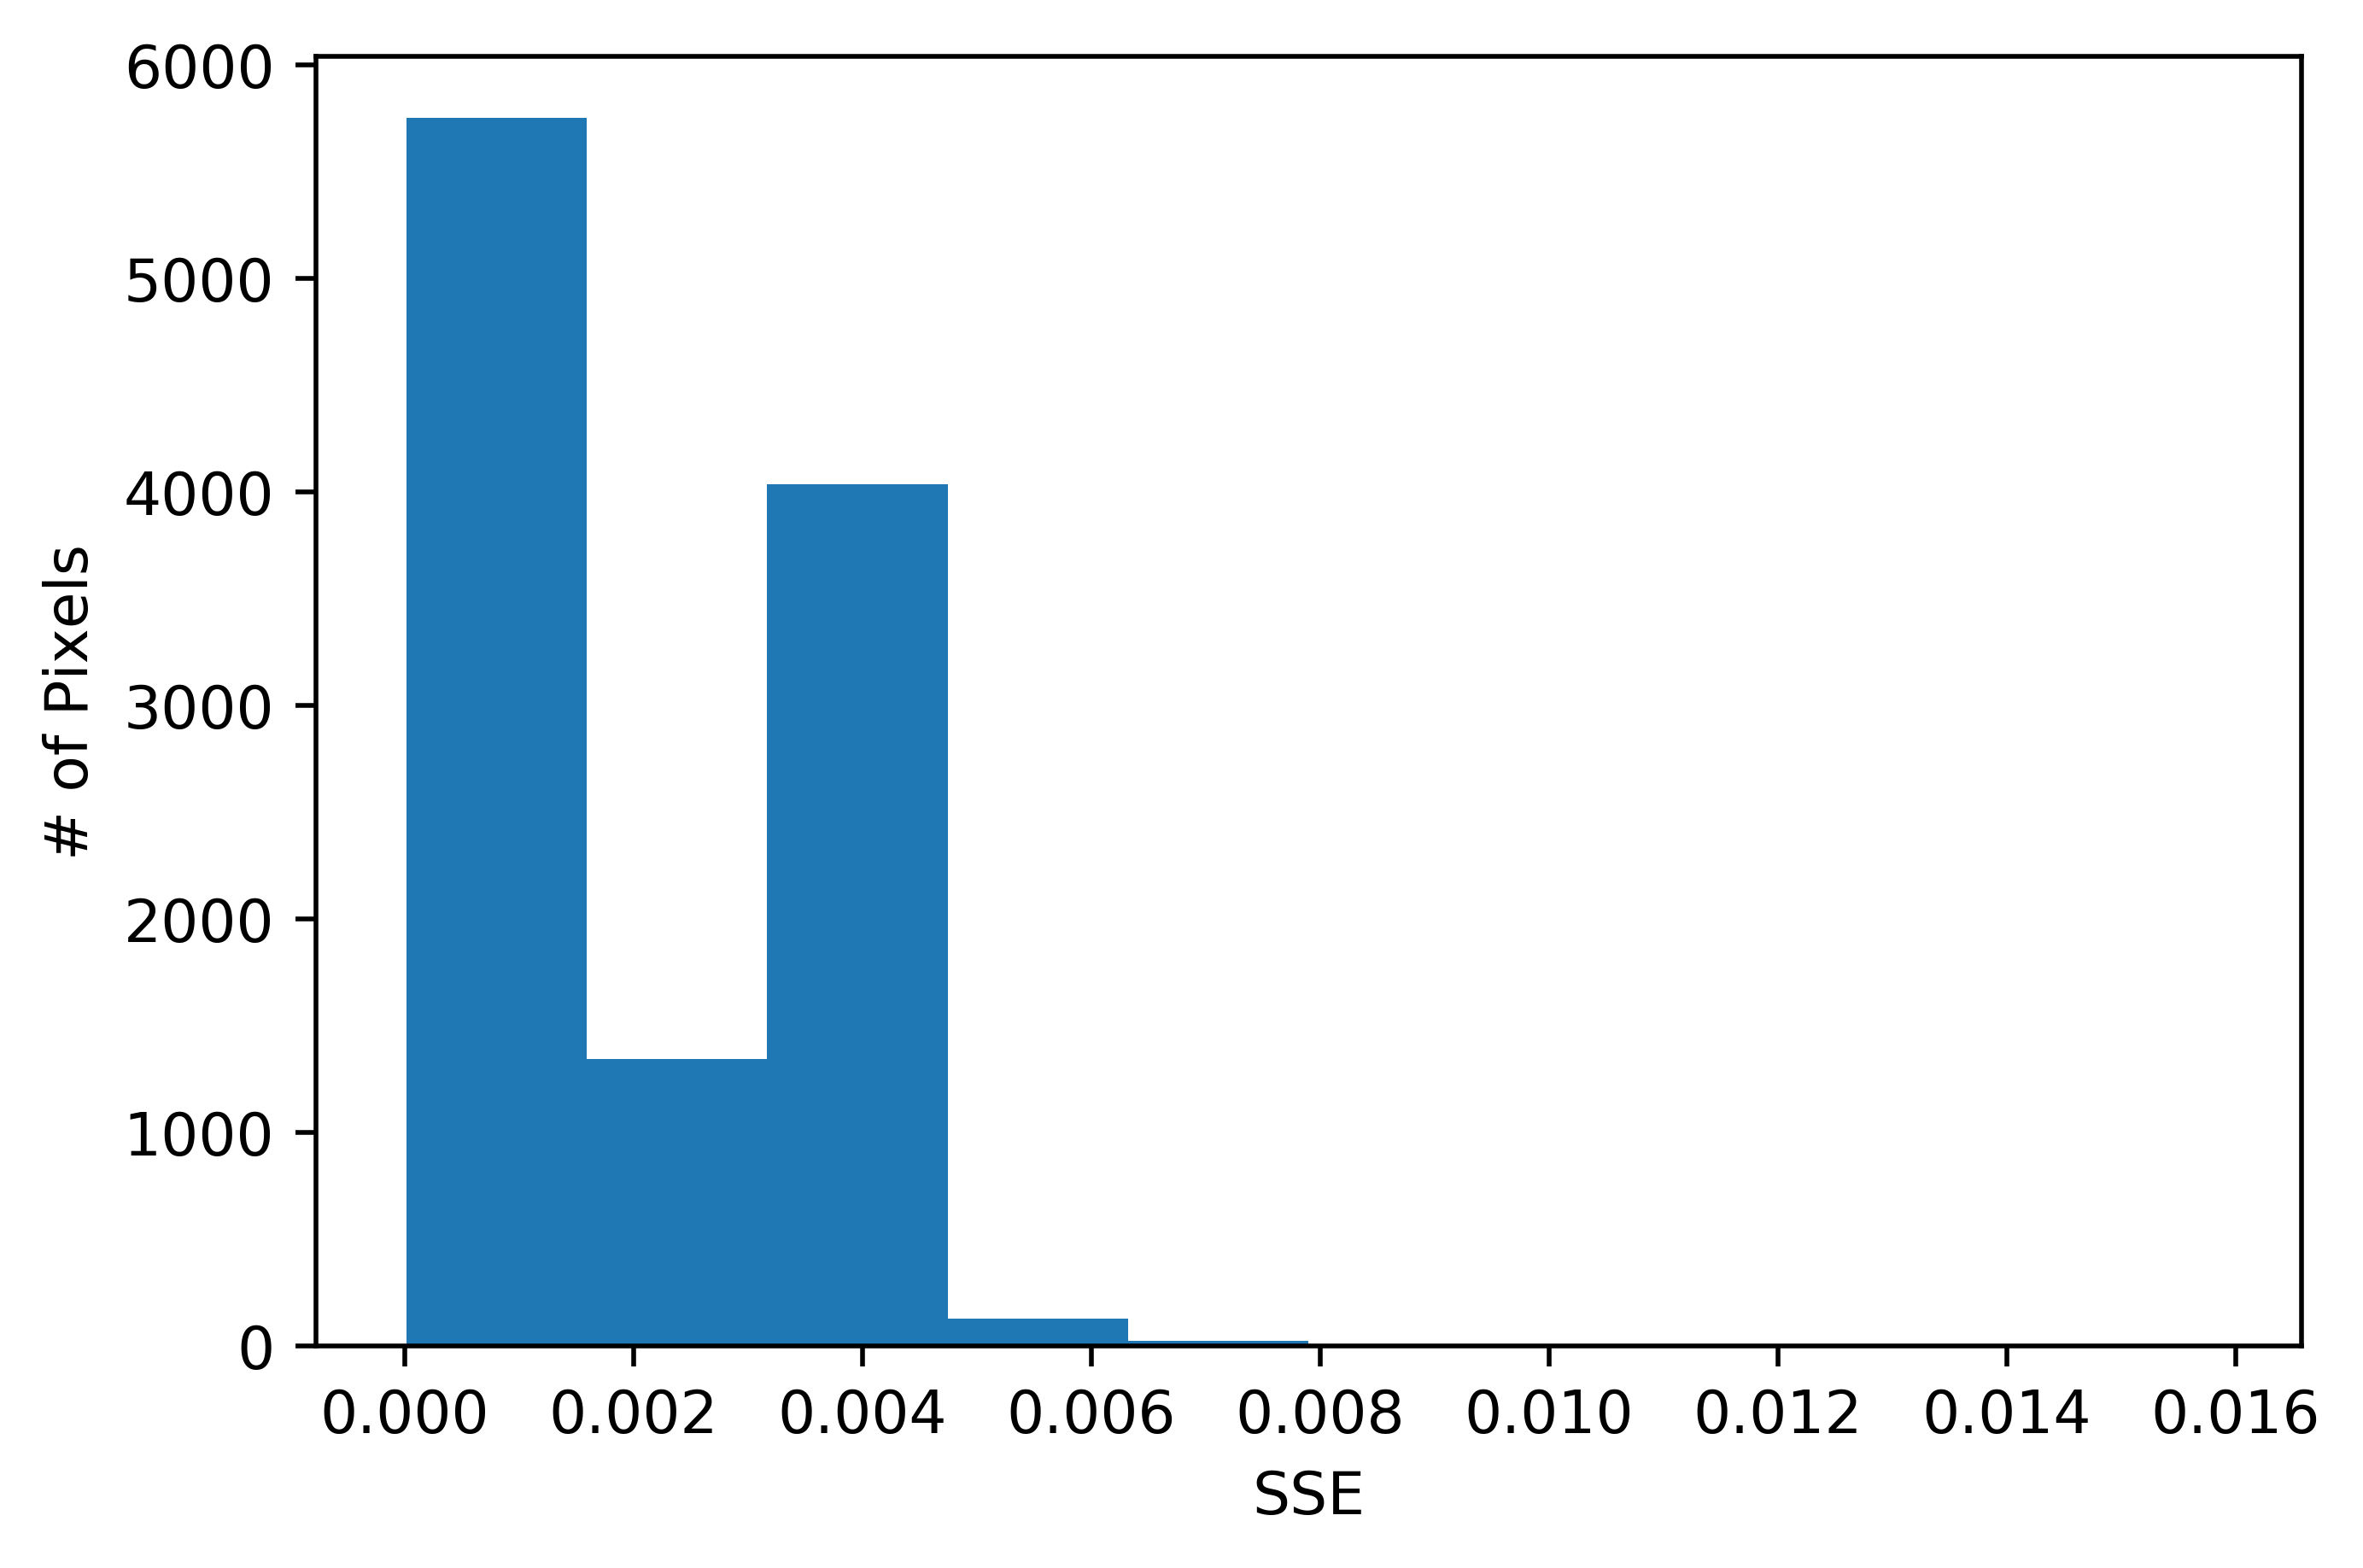

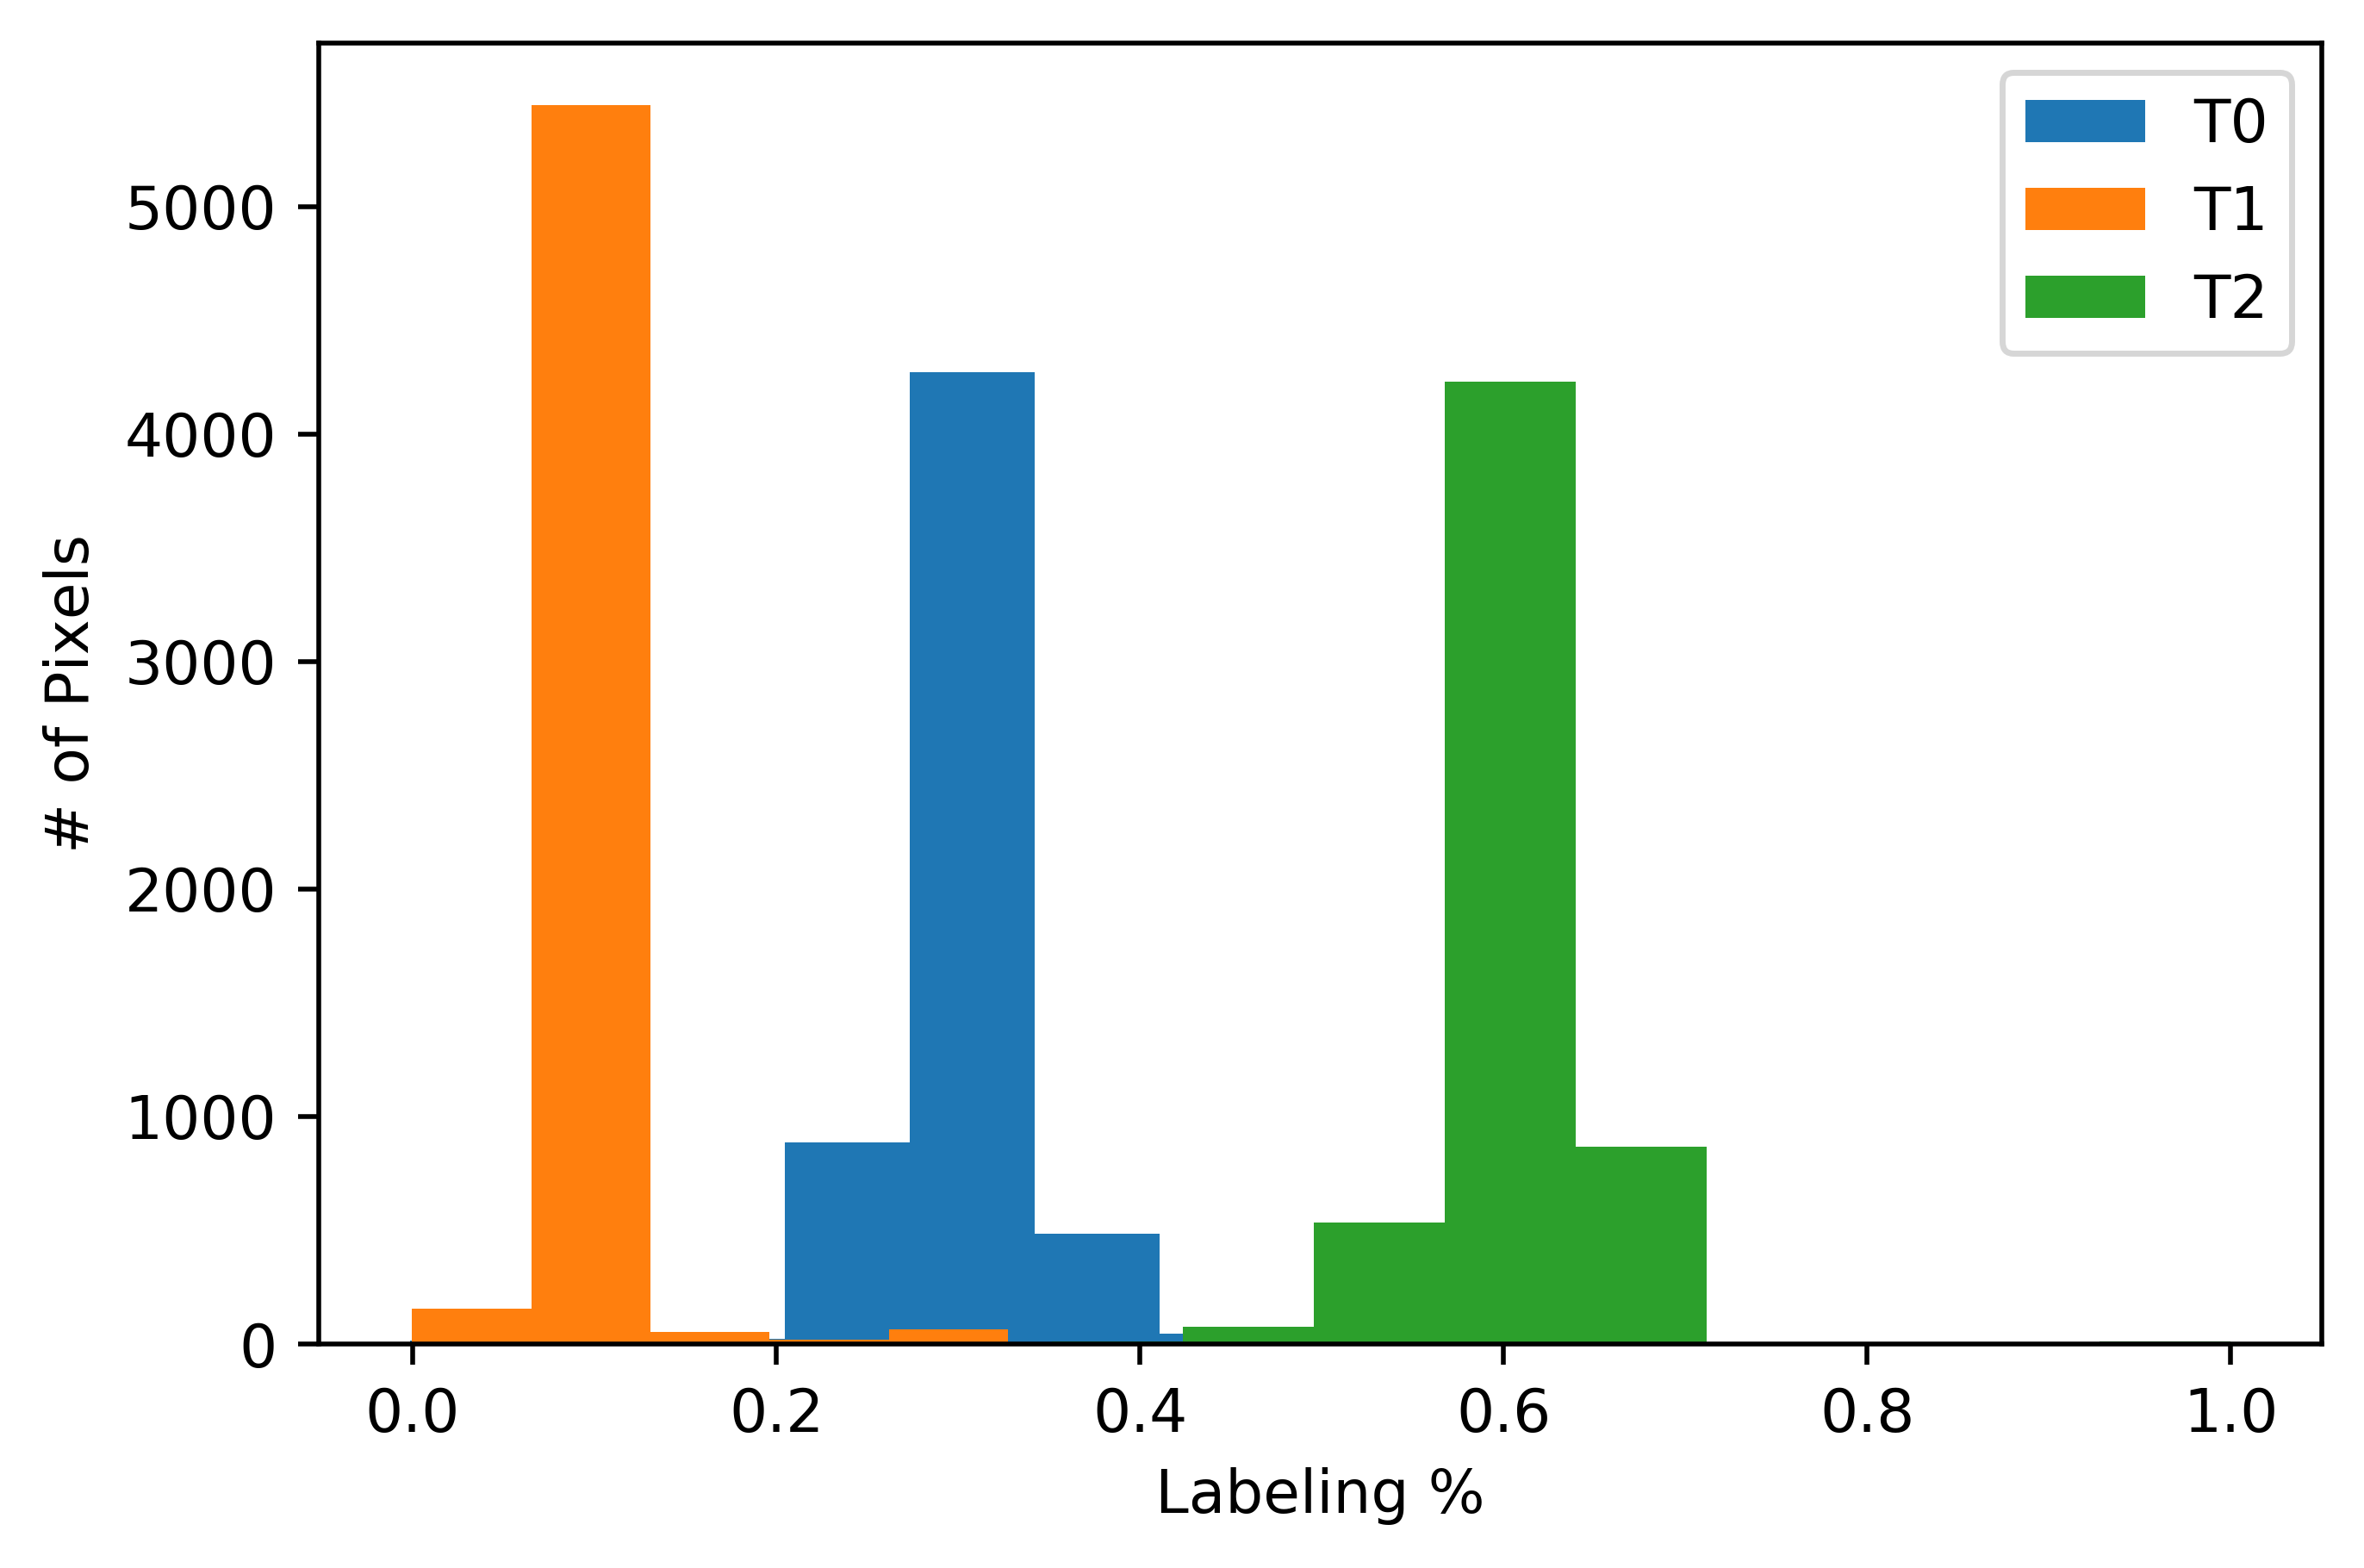

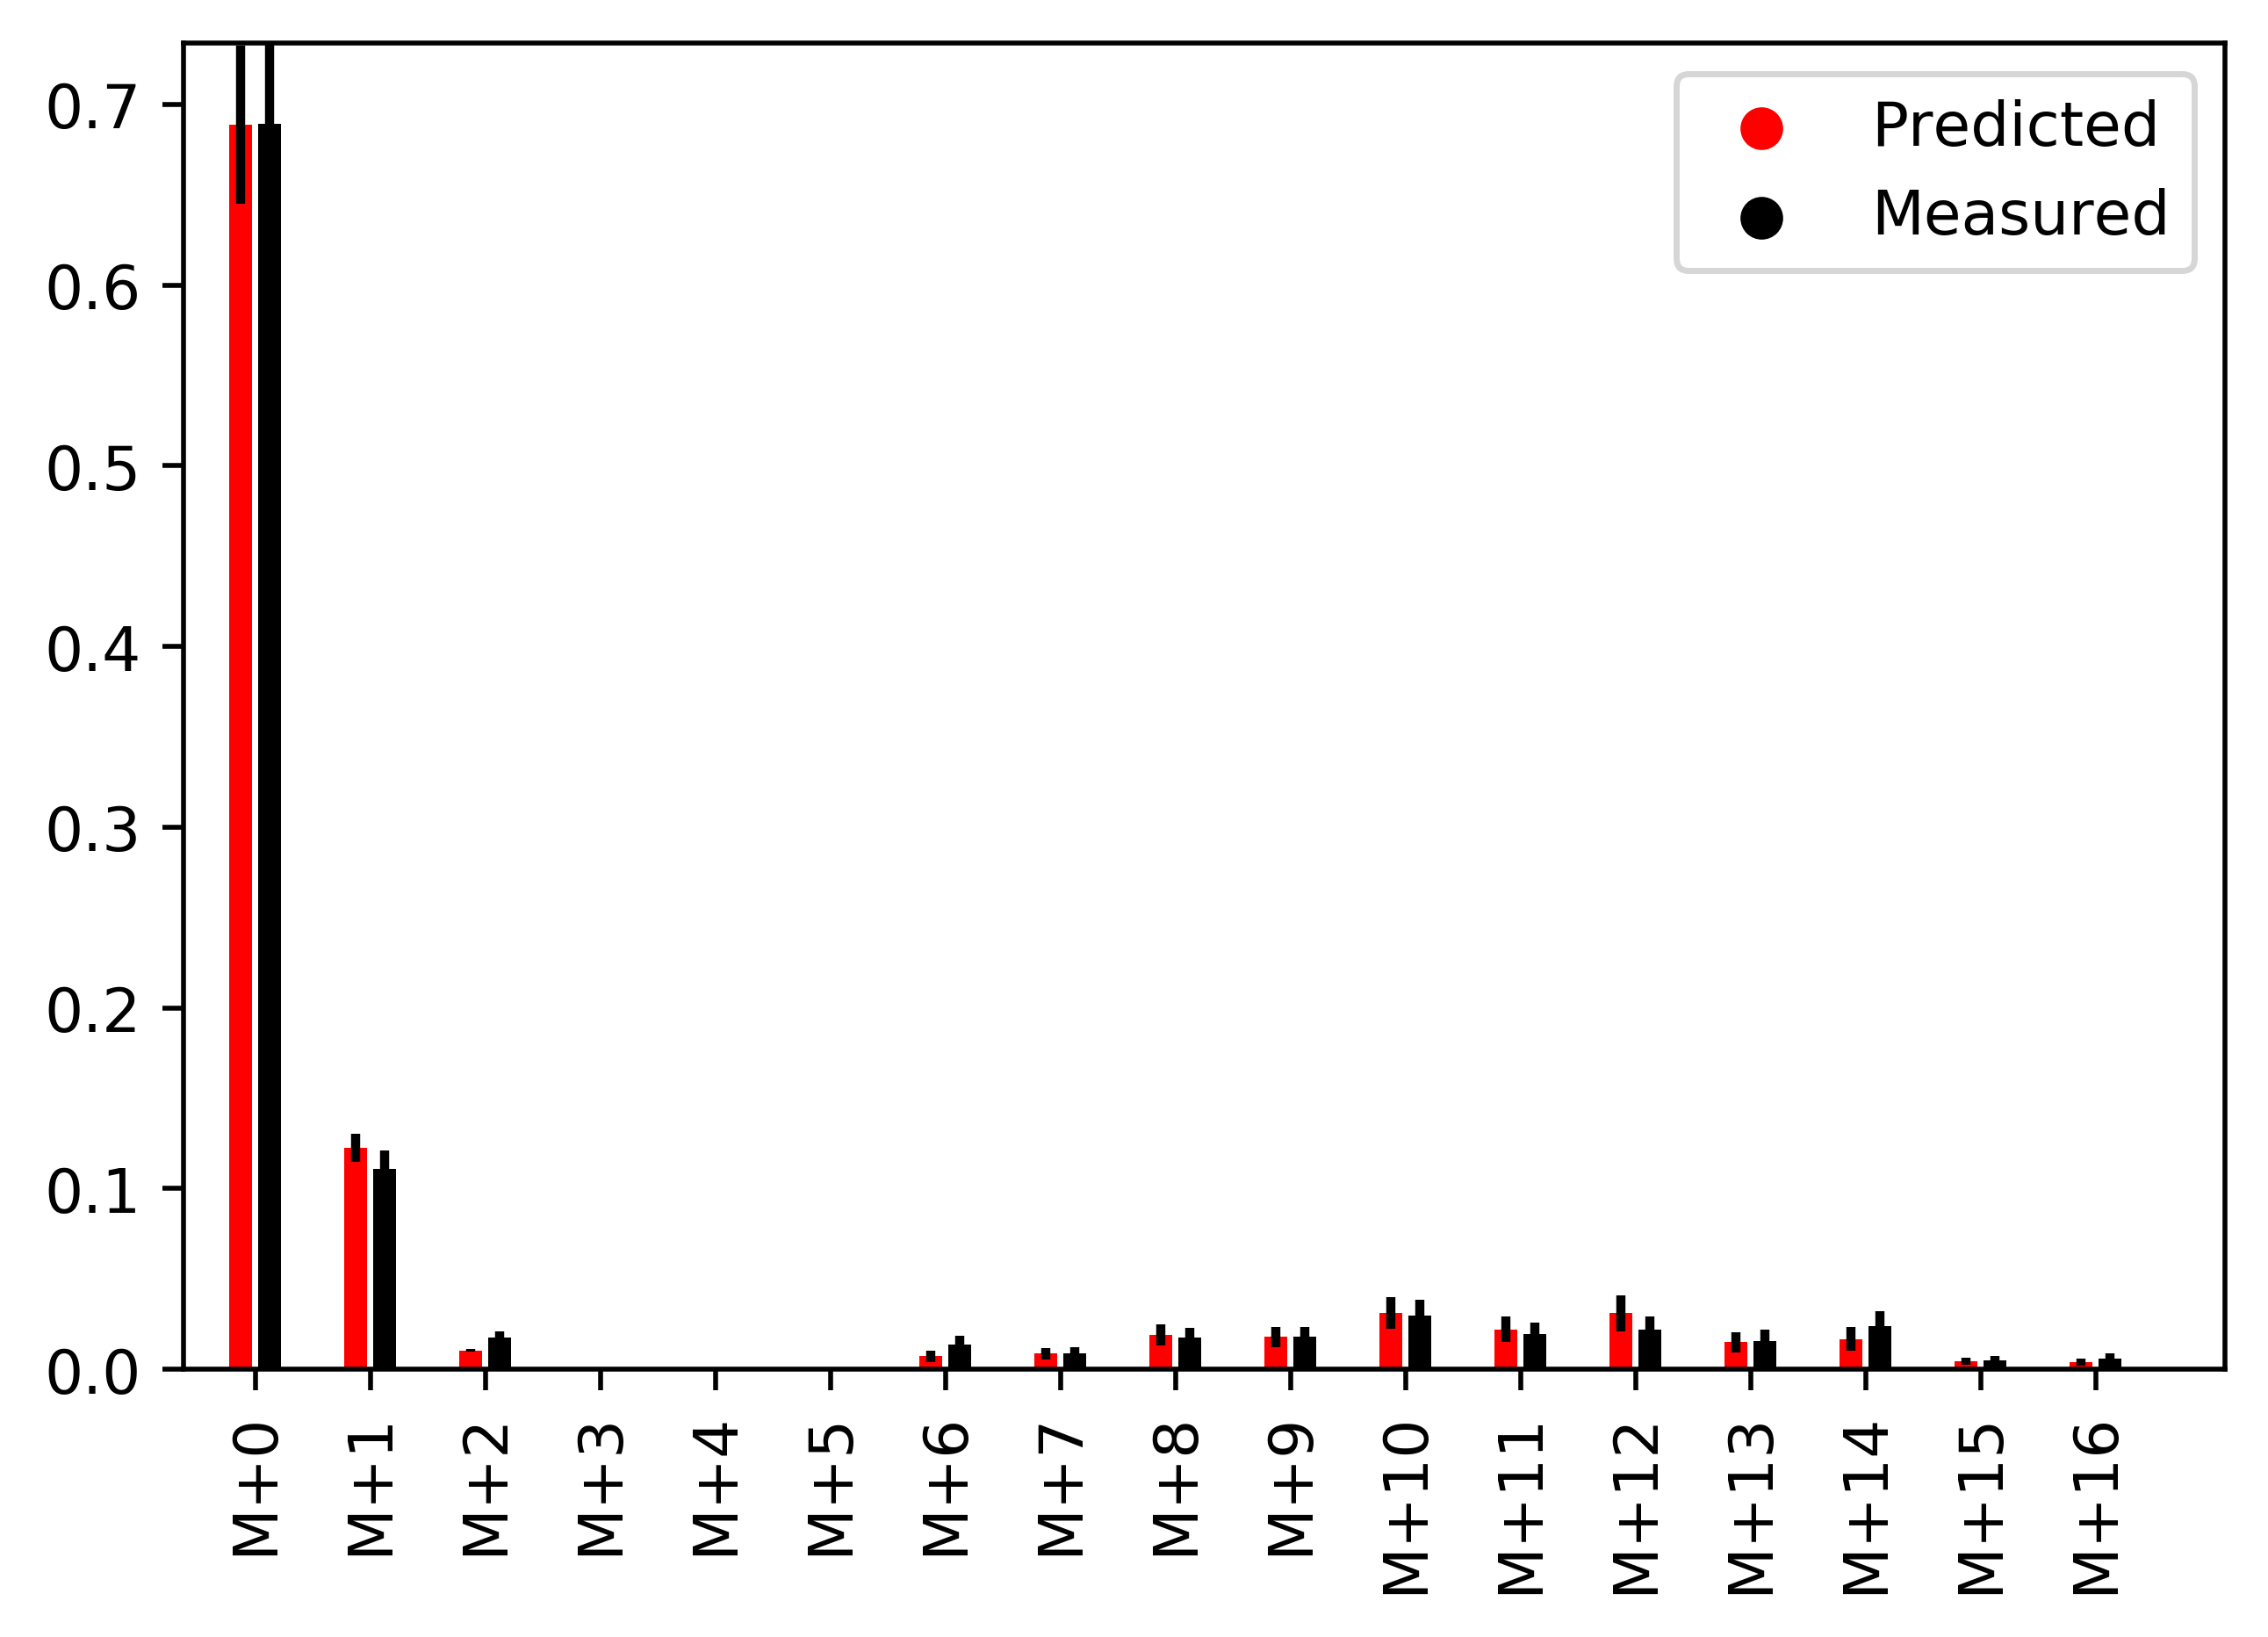

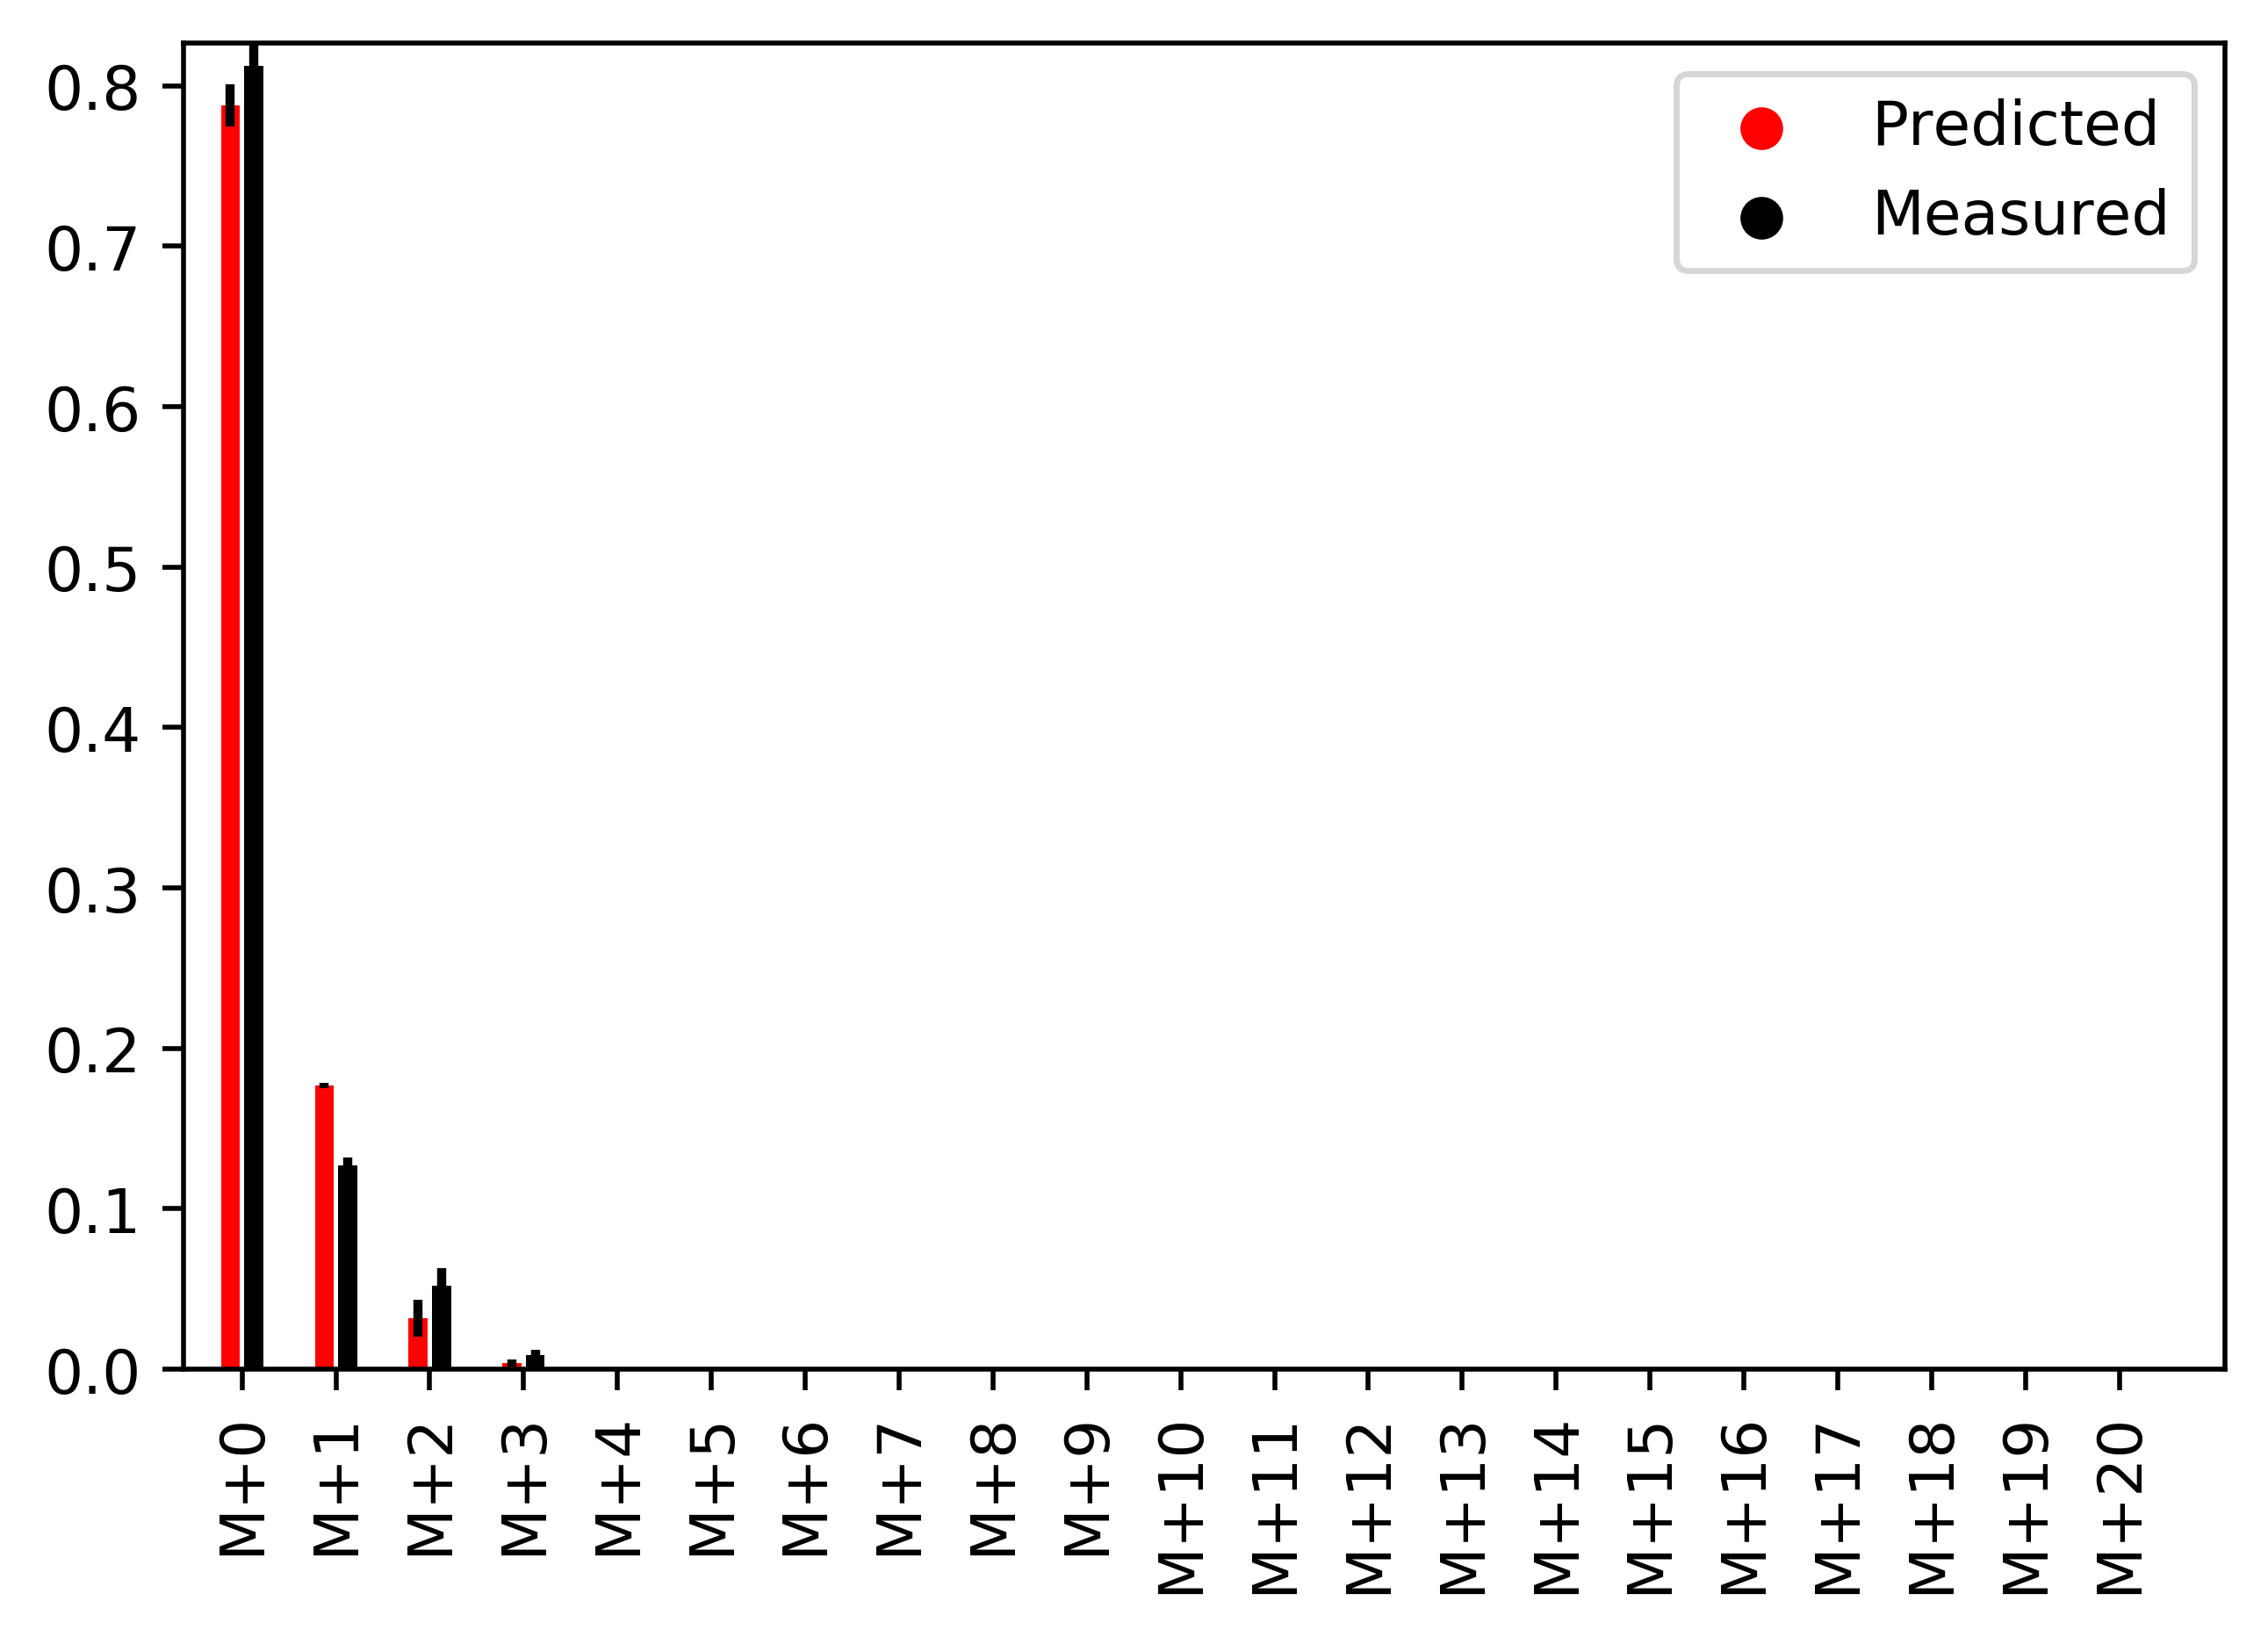

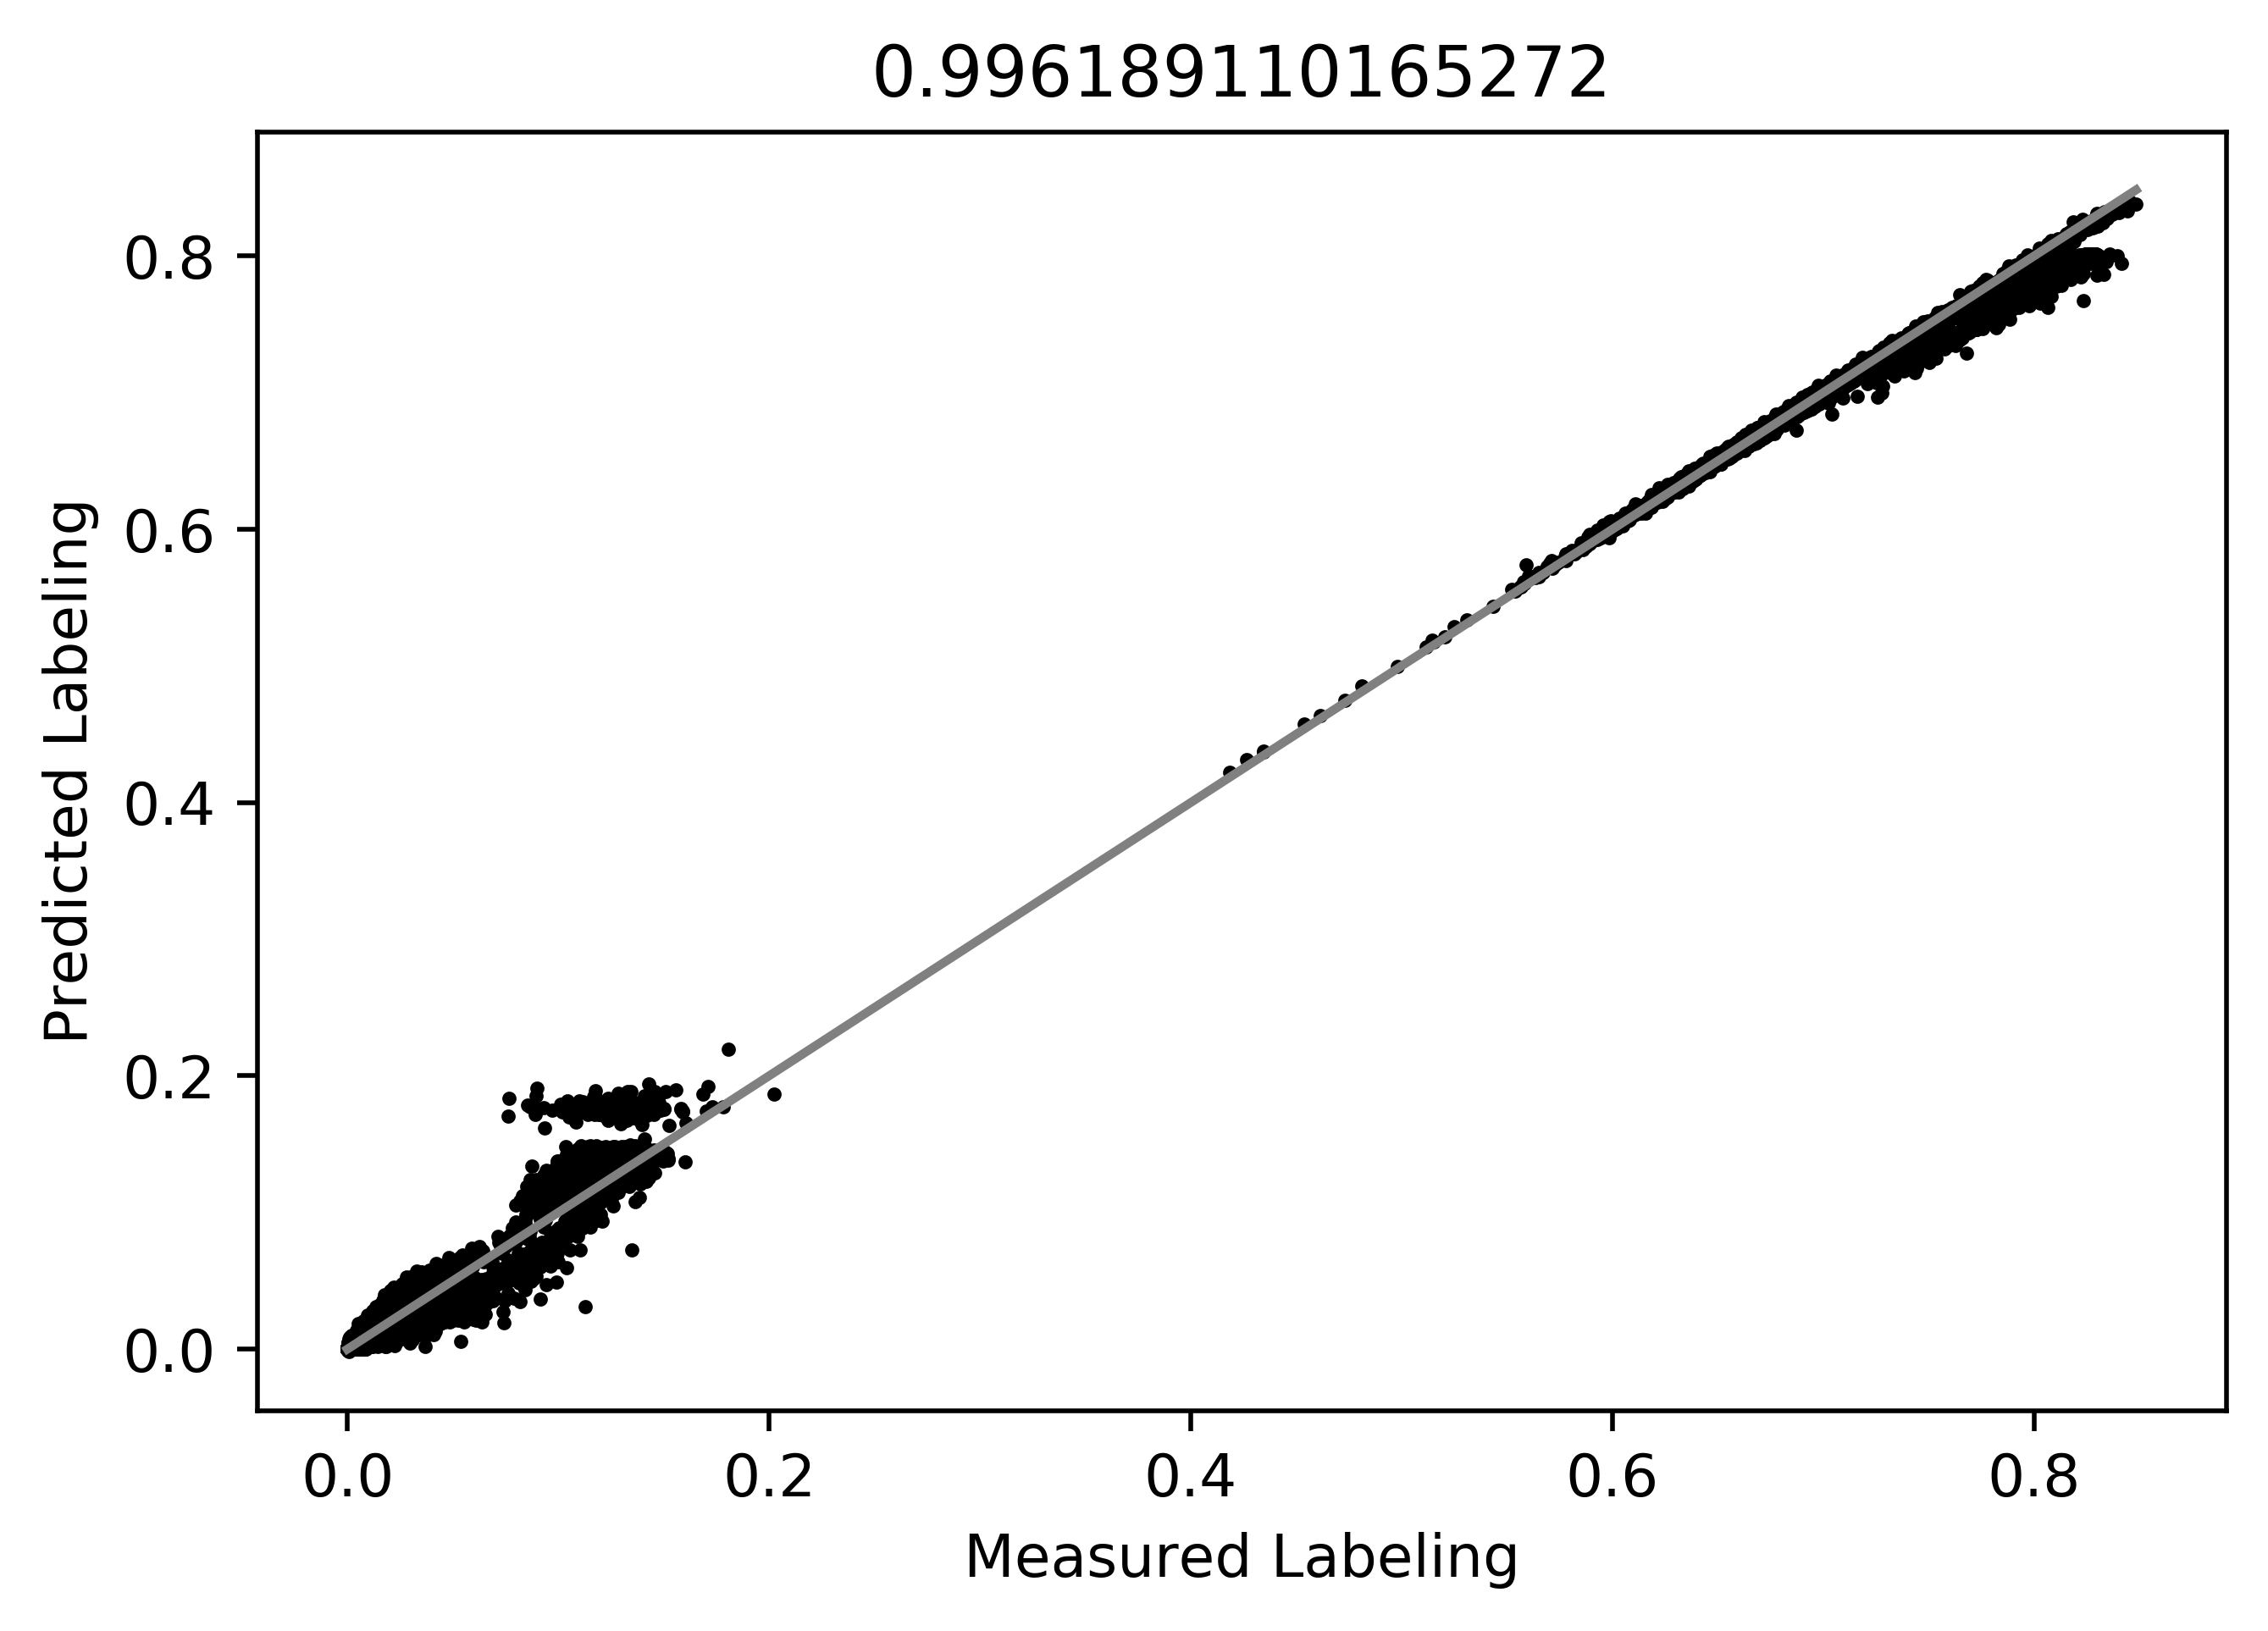

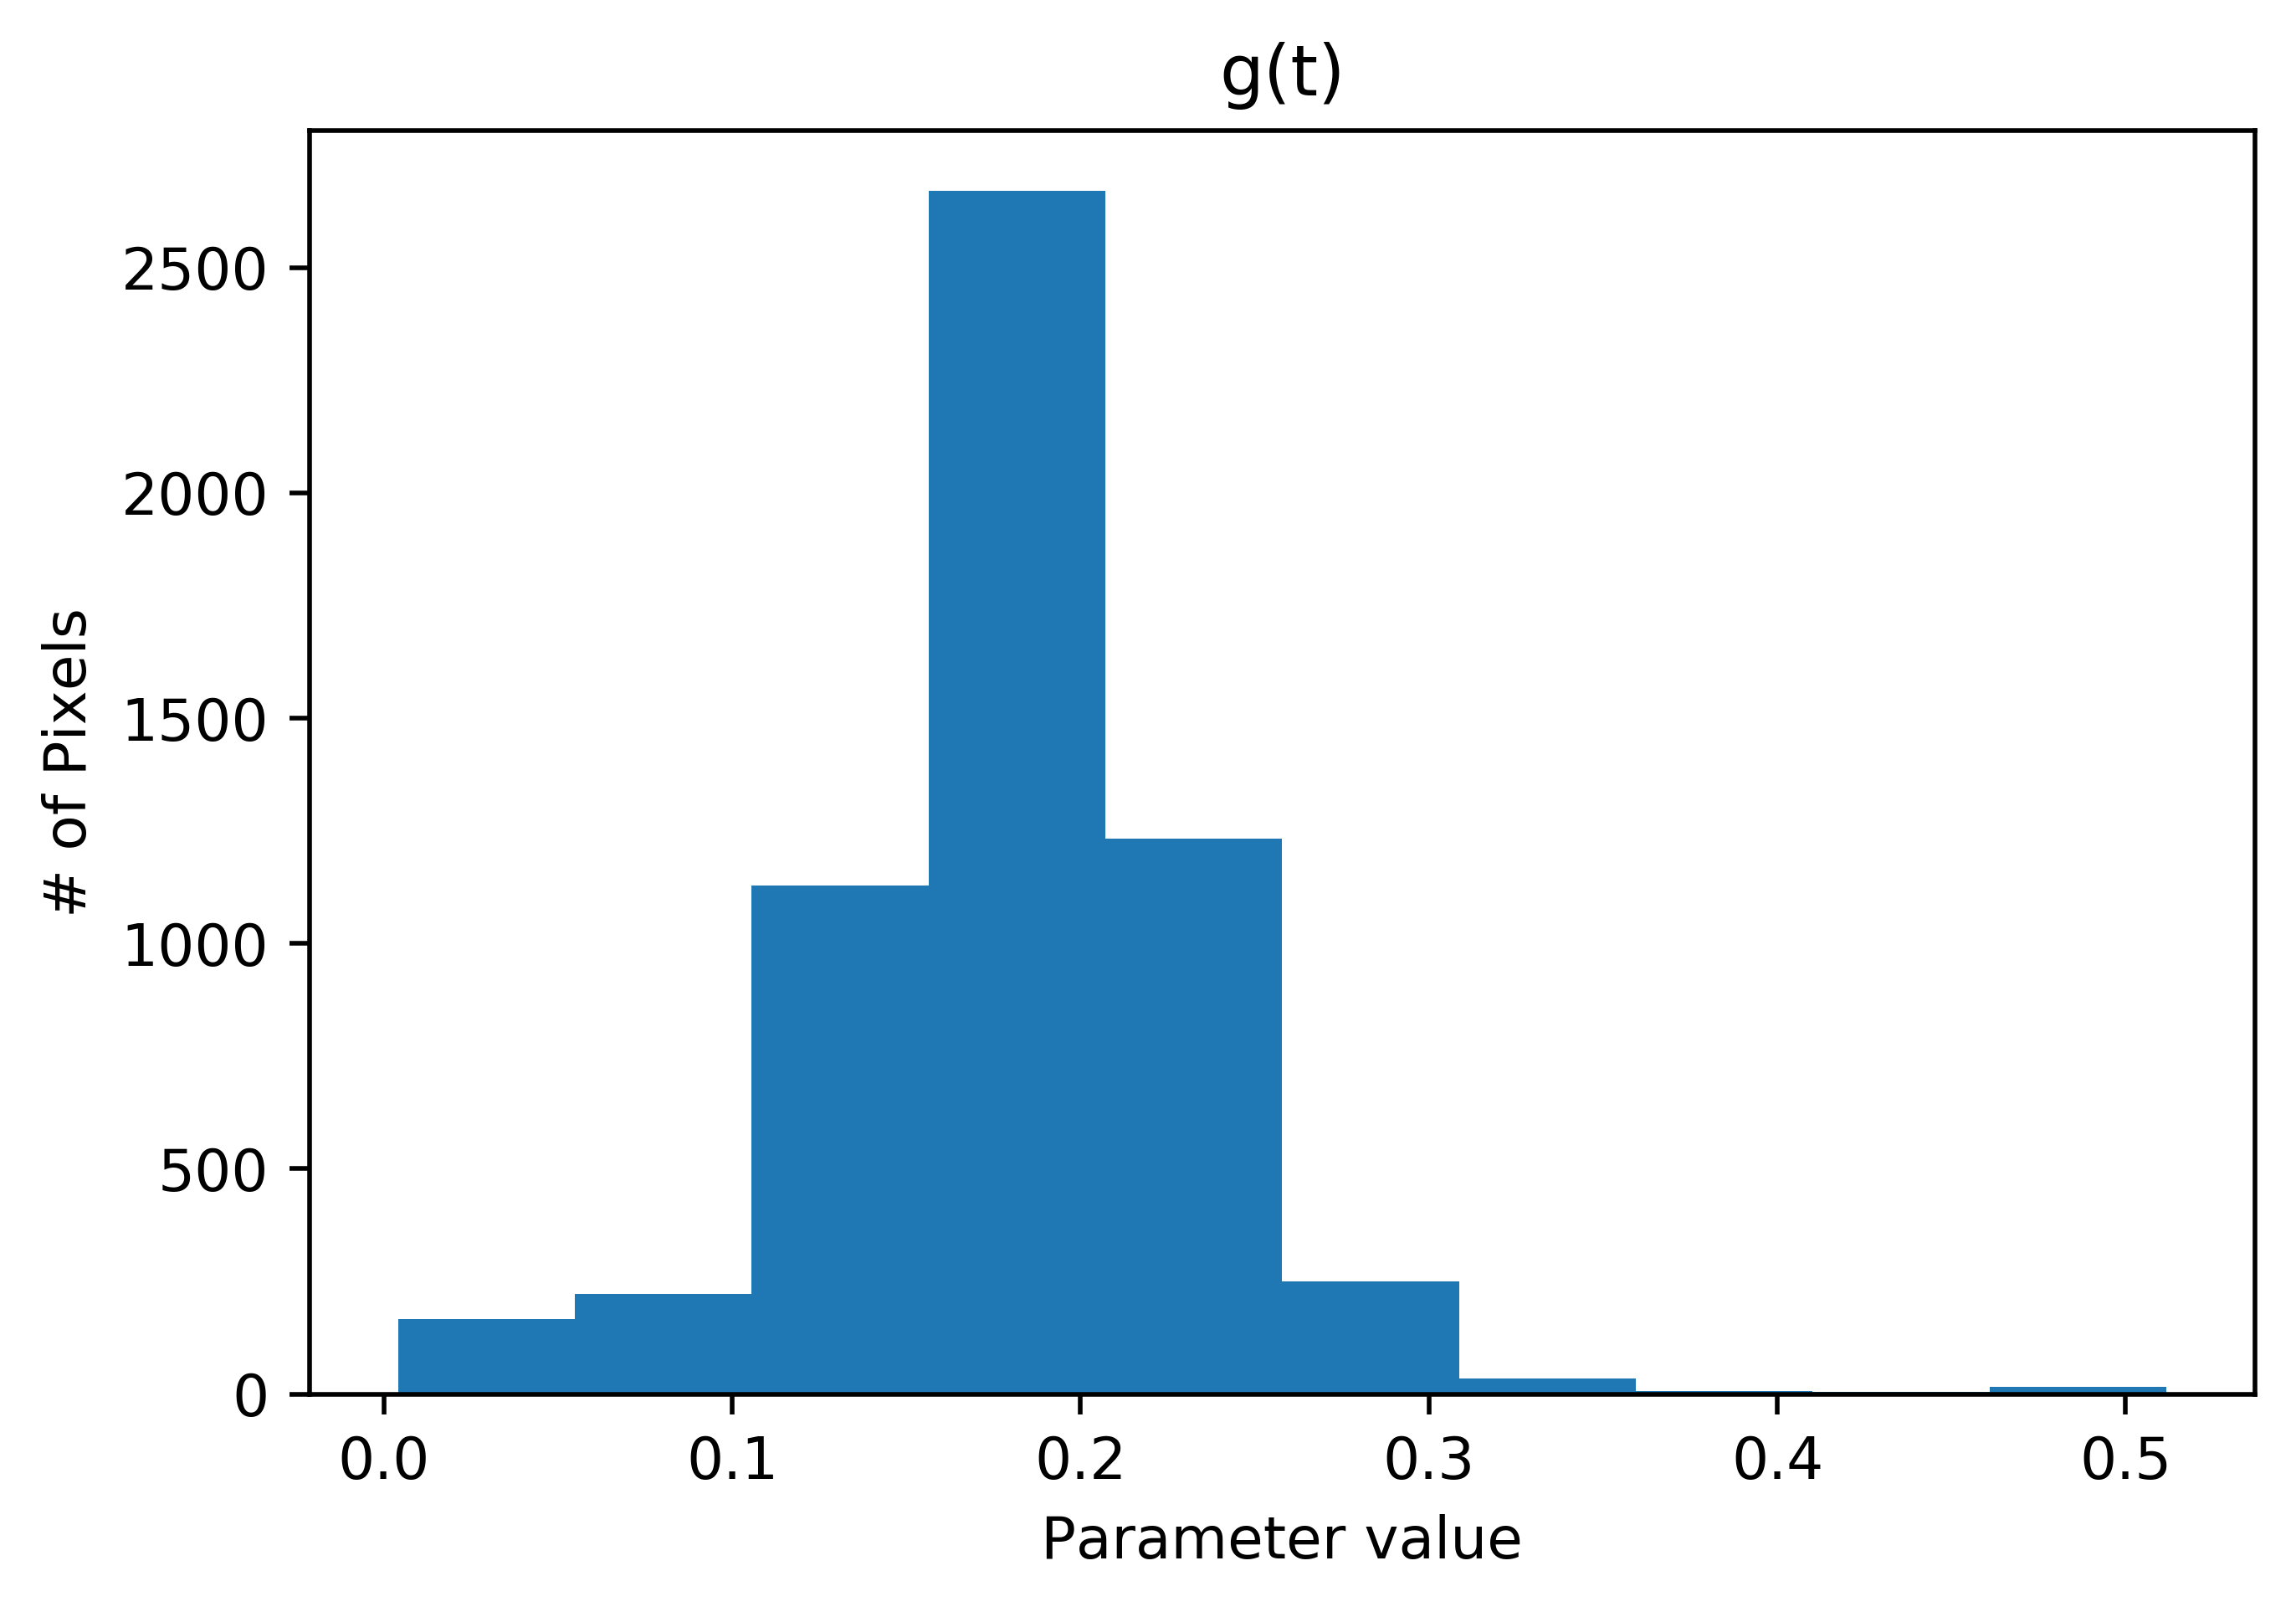

In [ ]:
myzip = zipfile.ZipFile(filename.replace(".txt","_" + formula + "_results.zip"),"w")

#show and save images
plt.imshow(fluxImageG,cmap=colormap)
im = Image.fromarray(fluxImageG)
im.save(filename.replace(".txt","") + "_" + palmitate_formula + "_g_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_g_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_g_" + '.tif')
plt.colorbar()
plt.title("g")

plt.figure()
plt.imshow(fluxImageE,cmap=colormap)
im = Image.fromarray(fluxImageE)
im.save(filename.replace(".txt","") + "_" + formula + "_e" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_e" + '.tif')
os.remove(filename.replace(".txt","") + "_" + formula + "_e" + '.tif')
plt.colorbar()
plt.title("e")

plt.figure()
plt.imshow(fluxImageD,cmap=colormap)
im = Image.fromarray(fluxImageD)
im.save(filename.replace(".txt","") + "_" + palmitate_formula + "_D_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_D_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_D_" + '.tif')
plt.title("D")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT0,cmap=colormap)
im = Image.fromarray(fluxImageT0)
im.save(filename.replace(".txt","") + "_" + palmitate_formula + "_T0_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_T0_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_T0_" + '.tif')
plt.title("T0")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT1,cmap=colormap)
im = Image.fromarray(fluxImageT1)
im.save(filename.replace(".txt","") + "_" + palmitate_formula + "_T1_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_T1_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_T1_" + '.tif')
plt.title("T1")
plt.colorbar()

plt.figure()
plt.imshow(fluxImageT2,cmap=colormap)
im = Image.fromarray(fluxImageT2)
im.save(filename.replace(".txt","") + "_" + palmitate_formula + "_T2_" + '.tif')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_T2_" + '.tif')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_T2_" + '.tif')
plt.title("T2")
plt.colorbar()

#plot histogram of sum of squared errors
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_" + palmitate_formula + "_sse" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_" + palmitate_formula + "_sse" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_" + palmitate_formula + "_sse" + '.png')

#output found tracer labeling
plt.figure()
T_founds = np.array([t/np.sum(t) for t in T_founds])
T_found = np.mean(T_founds,axis=0)
print("T (mean) = ",T_found)
for t in range(len(T_found)):
    plt.hist(T_founds[:,t],label="T"+str(t))
plt.legend()
plt.xlabel("Labeling %")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + palmitate_formula + "_T_hist" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_T_hist" + '.png')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_T_hist" + '.png')

plt.figure()
x_ind = 0
x_lab = []
meanPred = np.median(P_preds[:Ind],axis=0)
stdPred = np.std(P_preds[:Ind],axis=0)
meanTrue = np.median(P_trues[:Ind],axis=0)
stdTrue = np.std(P_trues[:Ind],axis=0)
maxY = np.max(np.concatenate((meanPred,meanTrue))) + np.max(np.concatenate((stdPred,stdTrue)))
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)
plt.scatter([-1],[-1],c="red",label="Predicted")
plt.scatter([-1],[-1],c="black",label="Measured")
plt.legend()
plt.ylim((0,maxY))
plt.xlim((-2,x_ind+1))
plt.savefig(filename.replace(".txt","") + "_" + palmitate_formula + "_pred_meas" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_"+ palmitate_formula + "_pred_meas" + '.png')
os.remove(filename.replace(".txt","") + "_"  + palmitate_formula + "_pred_meas" + '.png')

plt.figure()
x_ind = 0
x_lab = []
meanPred = np.median(P_preds[Ind:],axis=0)
stdPred = np.std(P_preds[Ind:],axis=0)
meanTrue = np.median(P_trues[Ind:],axis=0)
stdTrue = np.std(P_trues[Ind:],axis=0)
maxY = np.max(np.concatenate((meanPred,meanTrue))) + np.max(np.concatenate((stdPred,stdTrue)))
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)
plt.scatter([-1],[-1],c="red",label="Predicted")
plt.scatter([-1],[-1],c="black",label="Measured")
plt.legend()
plt.ylim((0,maxY))
plt.xlim((-2,x_ind+1))
plt.savefig(filename.replace(".txt","") + "_" + formula  + "_pred_meas" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_pred_meas" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula +  "_pred_meas" + '.png')

plt.figure()

trues = np.concatenate([np.array(P_trues[:Ind]).flatten(),np.array(P_trues[Ind:]).flatten()])
fit = np.concatenate([np.array(P_preds[:Ind]).flatten(),np.array(P_preds[Ind:]).flatten()])

plt.scatter(trues,fit,color="black",s=2)
plt.ylabel("Predicted Labeling")
plt.xlabel("Measured Labeling")
plt.title(r2_score(trues,fit))
plt.plot([0,np.max(np.concatenate((trues,fit)))],[0,np.max(np.concatenate((trues,fit)))],color="grey")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_" + palmitate_formula + "_scatter_plot" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_" + palmitate_formula + "_scatter_plot" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_" + palmitate_formula + "_scatter_plot" + '.png')

plt.figure()
plt.hist(fluxImageG[fluxImageG > 0].flatten())
plt.title("g(t)")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + palmitate_formula + "_hist_g" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_hist_g" + '.png')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_hist_g" + '.png')

plt.figure()
plt.hist(fluxImageD[fluxImageD > 0].flatten())
plt.title("D")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + palmitate_formula + "_hist_d" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + palmitate_formula + "_hist_d" + '.png')
os.remove(filename.replace(".txt","") + "_" + palmitate_formula + "_hist_d" + '.png')

plt.figure()
plt.hist(fluxImageE[fluxImageE > 0].flatten())
plt.title("e(t)")
plt.xlabel("Parameter value")
plt.ylabel("# of Pixels")
plt.savefig(filename.replace(".txt","") + "_" + formula + "_hist_e" + '.png')
helper.write_file_to_zip(myzip,filename.replace(".txt","") + "_" + formula + "_hist_e" + '.png')
os.remove(filename.replace(".txt","") + "_" + formula + "_hist_e" + '.png')


myzip.close()